In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import skimage.io as io
from skimage import util

from glob import glob
import ast


In [3]:
def plot_one_entity(images_dict,props):
    file_name=props["file_name"]
    frame=props["frame"]
    ind=props["index"]
    img=images_dict[file_name]['img'][frame]
    segmented=images_dict[file_name]['binary'][frame]
    
    
    f = plt.figure(figsize=(50,15))
    ax_img = f.add_subplot(161)
    ax_region_ext = f.add_subplot(162)
    ax_region_ext_seg = f.add_subplot(163)
    ax_label = f.add_subplot(164)
    
    # ax_img
    ax_img.imshow(img,cmap="gray")
    min_row,min_col,max_row,max_col=props.loc["bbox-0":"bbox-3"].values.astype(int)
    rect =matplotlib.patches.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row,fill=False, edgecolor='red', linewidth=3)
    ax_img.add_patch(rect)
    ax_img.axis("off")
    ax_img.set_title("file_name={} \n frame={} \n index={}".format(file_name,frame,ind))
    ax_img.axis("off")
    
    # ax_region_ext
    delta=7
    min_row_ext=np.max([0,min_row-delta])
    max_row_ext=max_row+delta
    min_col_ext=np.max([0,min_col-delta])
    max_col_ext=max_col+delta
    ax_region_ext.imshow(img[min_row_ext:max_row_ext,min_col_ext:max_col_ext],cmap="gray")
    
    if (props["is_peaks"]==True):
        list_peaks=ast.literal_eval(props["peaks"])
        plot_peaks(ax_region_ext,list_peaks,delta)
    ax_region_ext.axis("off")
    
    # ax_segment
    ax_region_ext_seg.imshow(segmented[min_row_ext:max_row_ext,min_col_ext:max_col_ext],cmap="gray")
    ax_region_ext_seg.axis("off")
    
    #attributes
    attributes_intenisty="frame={:.2f} \n  max_intensity={:.2f} \n mean_intensity={:.2f} \n min_intensity={:.2f} \n contrast={:.2f}\n".format(props['frame'],props['max_intensity'],props['mean_intensity'],props['min_intensity'],props["contrast"])
    attributes_shape="area={:.2f} \n eccentricity={:.2f} \n compactness={:.2f} \n circularity={:.2f}\n".format(props["area"],props["eccentricity"],props['compactness'],props['circularity'])
    attributes_geometry="minor={:.2f}   major={:.2f}\n".format(props["minor_axis_length"],props["major_axis_length"])
    
    attributes=attributes_intenisty+attributes_shape+attributes_geometry                                                                                                
    ax_label.text(0,0.5,attributes)
    ax_label.axis("off")
    
    
    #plt.tight_layout()
    

def plot_peaks(ax_region_ext,list_coord,delta):
    Row=[]
    Col=[]
        
    for peak in list_coord:
        row,col,intensity=peak
        Row.append(row+delta)
        Col.append(col+delta)
    ax_region_ext.plot(Col,Row,'r.',marker='o',markersize=10.0)

## Measurements
List of the measurements

Geometric
* centroid
* major_axis_length
* minor_axis_length
* orientation. Angle between the 0th axis (rows) and the major axis of the ellipse that has the same second moments as the region, ranging from -pi/2 to pi/2 counter-clockwise.
* area
* perimeter
* eccentricity. Eccentricity of the ellipse that has the same second-moments as the region. The eccentricity is the ratio of the focal distance (distance between focal points) over the major axis length. The value is in the interval [0,1] When it is 0, the ellipse becomes a circle.
* bbox
* compactness. 4pi for the circle, 16 for the square
* circularity. 1 for the circle ( it is maximum value and pi/4 for the square)

Intensity
* min_intensity
* mean_intensity
* max_intensity
* contrast

Local peaks within labeled region
* peaks
* is_peak (False- no peaks were found, True - several peaks were found)



## Physical units

In [4]:
dxx=1.42 # px/mkm 
dt=6 #s

In [5]:
file_list=glob("../data/*_Dark_prepared.tif")

images_dict={}
for file_name in file_list:
    images_prepared=io.imread(file_name)
    binary_file=file_name.split(".tif")[0]+'_segmented'+'.tif'
    images_binary=io.imread(binary_file)
    img_dict={"img":images_prepared,"binary":images_binary}
    file_prefix=os.path.split(file_name)[1].split('.')[0].split("_prepared")[0]
    images_dict[file_prefix]=img_dict


In [6]:
images_dict.keys()

dict_keys(['43125_Dark', '43121_Dark', '43122_Dark', '43123_Dark'])

In [7]:
Data=pd.read_csv("../data/Measurements.csv")

In [8]:
Data.shape

(50610, 25)

## Filter

In [9]:
Data=Data[Data.area>25]
print(Data.shape)

(37646, 25)


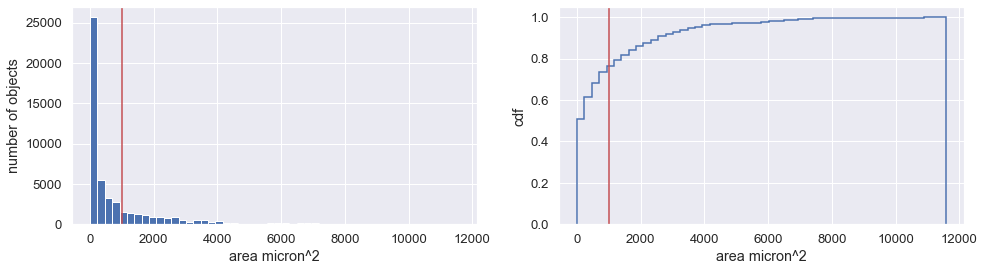

In [46]:
sns.set(font_scale=1.2)
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16, 4))

# plot the cumulative histogram
ax[0].hist(Data["area"]*dxx*dxx,bins=50)
ax[0].set_xlabel("area micron^2")
ax[0].set_ylabel("number of objects")
ax[0].axvline(500*dxx*dxx,color='r')
n, bins, patches = ax[1].hist(Data["area"]*dxx*dxx, bins=50, density=True, histtype='step',
                           cumulative=True, linewidth=1.5,label='Empirical')
ax[1].set_xlabel("area micron^2")
ax[1].set_ylabel("cdf")
ax[1].axvline(500*dxx*dxx,color='r')

plt.savefig("../results/Histogramm_detected_objects.png",bbox_inches="tight")

In [37]:
500*dxx*dxx

1008.1999999999999

  ## Number of objects

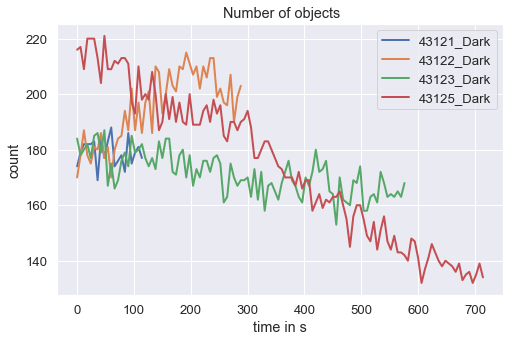

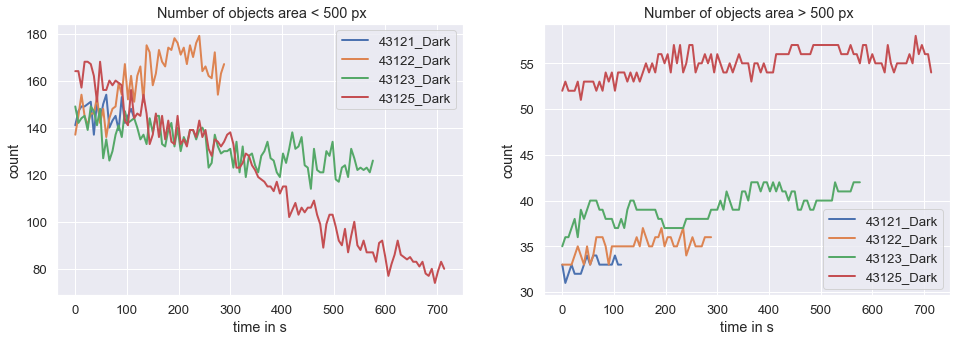

In [51]:
# calculate number of objects
def calculate_number_objects_per_frame(Data,ax):
    df_Counter=pd.DataFrame()
    for id, group in Data.groupby('file_name'):
        Count=group.groupby('frame').apply(lambda x: len(x['area']))
        df_counter=Count.reset_index('frame')
        df_counter=df_counter.rename(columns={df_counter.columns[1]:"Count"})
        df_counter["file_name"]=id
        df_Counter=pd.concat([df_Counter,df_counter])
    
    for id,group in df_Counter.groupby("file_name"):
        ax.plot(group["frame"]*dt,group["Count"],label=id,lw=2)
    ax.legend()
    
    return df_Counter

#####################################################
# plot results
#####################################################


fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(8,5),sharex=True)
ax.set_title(" Number of objects")
ax.set_xlabel("time in s")
ax.set_ylabel("count")
df_Counter=calculate_number_objects_per_frame(Data,ax)
plt.savefig("../results/Number_of_objects.png",bbox_inches="tight")

#####################################################
# plot results big (over 500px and small less than 1000 px)
#####################################################
Data_small=Data[Data.area<500]
Data_big=Data[Data.area>500]

fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(16,5),sharex=True)
ax[0].set_title(" Number of objects area < 500 px")
ax[0].set_xlabel("time in s")
ax[0].set_ylabel("count")
df_Counter_small=calculate_number_objects_per_frame(Data_small,ax[0])


ax[1].set_title(" Number of objects area > 500 px")
ax[1].set_xlabel("time in s")
ax[1].set_ylabel("count")
df_Counter_big=calculate_number_objects_per_frame(Data_big,ax[1])

plt.savefig("../results/Number_of_objects_big_small.png",bbox_inches="tight")

## Pair plots

In [1]:
att_list=['area','perimeter', 'eccentricity','mean_intensity','compactness', 'circularity', 'contrast',]

for id, group in Data.groupby('file_name'):
    sns_plot=sns.pairplot(data=group[att_list],kind="hist")
    plt.savefig("../results/"+id+"_pair_plot.png")

NameError: name 'Data' is not defined

## Area distributions

In [13]:
def plot_2d_histogramme(nframes,x,y,x_label,y_label,title,ax):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    # Big bins
    sns.set(font_scale=1.5)
    
    pl=ax.hist2d(x, y, bins=[nframes,15], cmap=plt.cm.jet);
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.grid(False)
    cbar=fig.colorbar(pl[3], ax=ax)
    cbar.set_label("counts ")
    #fig.savefig(path+attr+"_2dhist.png",bbox_inches=None)
    
def plot_2d_hist_area(Data,title):
    counter=0
    fig,ax =plt.subplots(nrows=1, ncols=4,figsize=(30,6))
    for id, group in Data.groupby("file_name"):
        #print(id,cut)
        nframes=np.max(group['frame'])+1
        x=group['frame']*dt
        y=group['area'] #*dxx*dxx
        plot_2d_histogramme(nframes,x,y,"time seconds","area mkm^2",id+title,ax[counter])
        counter=counter+1

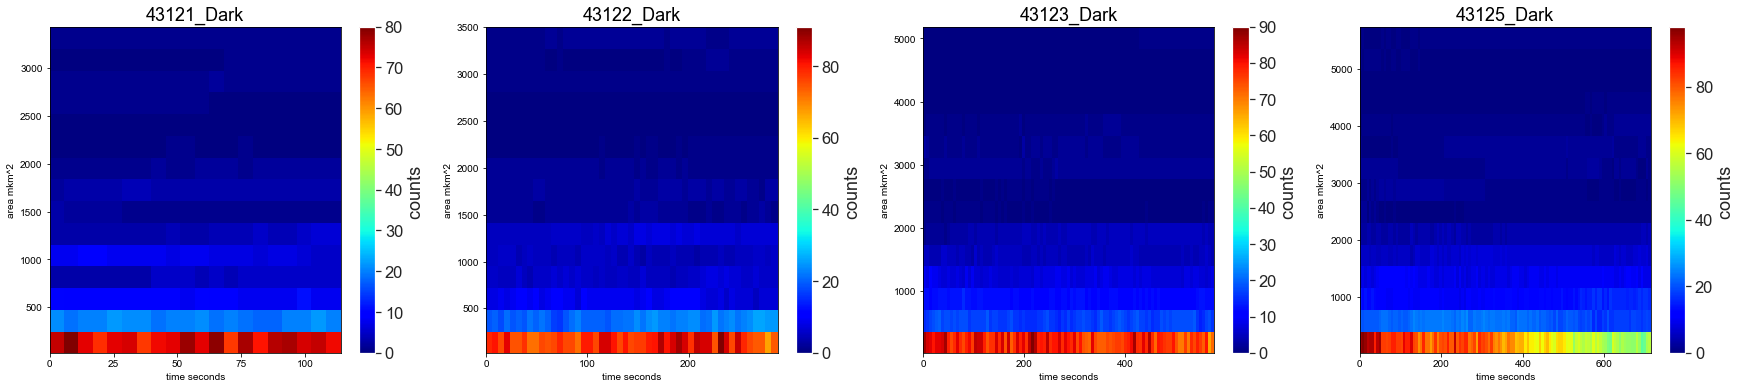

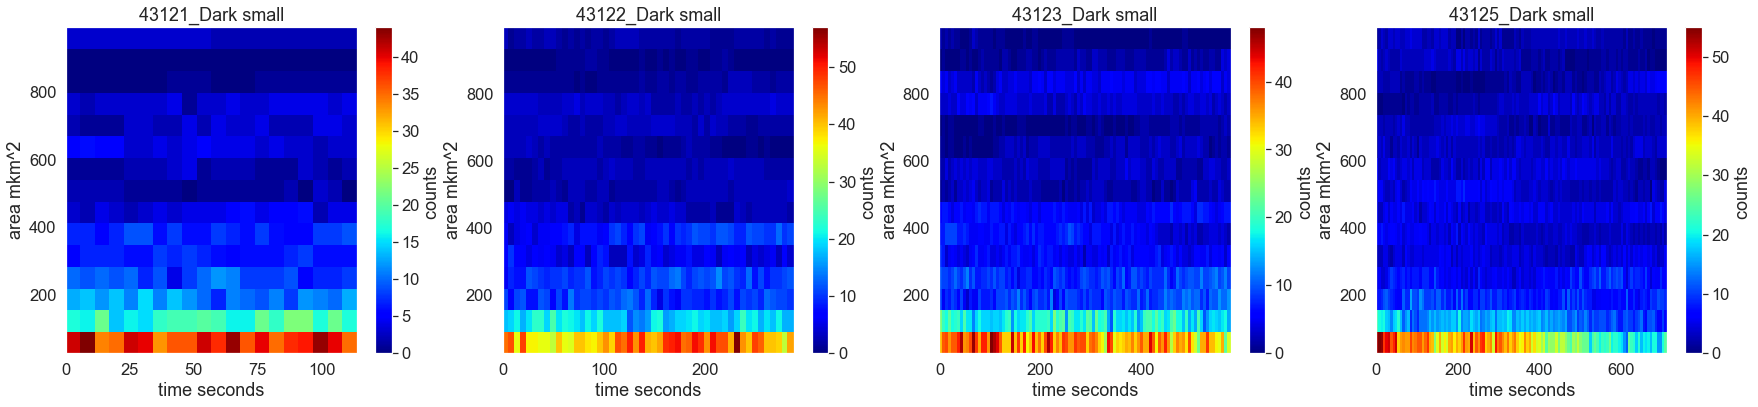

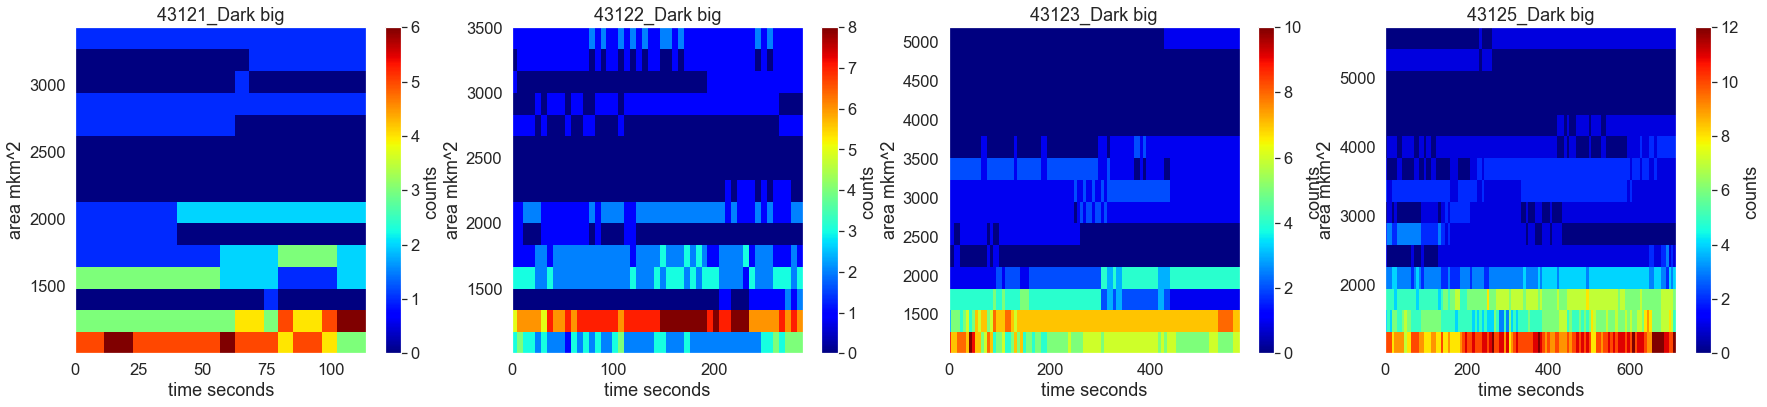

In [14]:
plot_2d_hist_area(Data,"")
plot_2d_hist_area(Data_small," small")
plot_2d_hist_area(Data_big," big")


## Examples

### compactness
Higher values mean more complex structure

Text(0, 0.5, 'count')

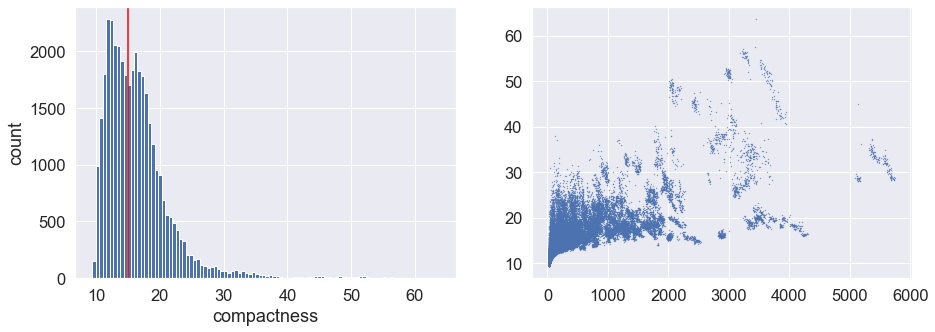

In [15]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,5))
ax[0].hist(Data["compactness"],bins=100)
ax[0].set_xlabel("compactness")
ax[0].set_ylabel("count")
ax[0].axvline(x=15,color='red')

ax[1].scatter(Data["area"],Data["compactness"],s=0.1,)
ax[0].set_xlabel("compactness")
ax[0].set_ylabel("count")


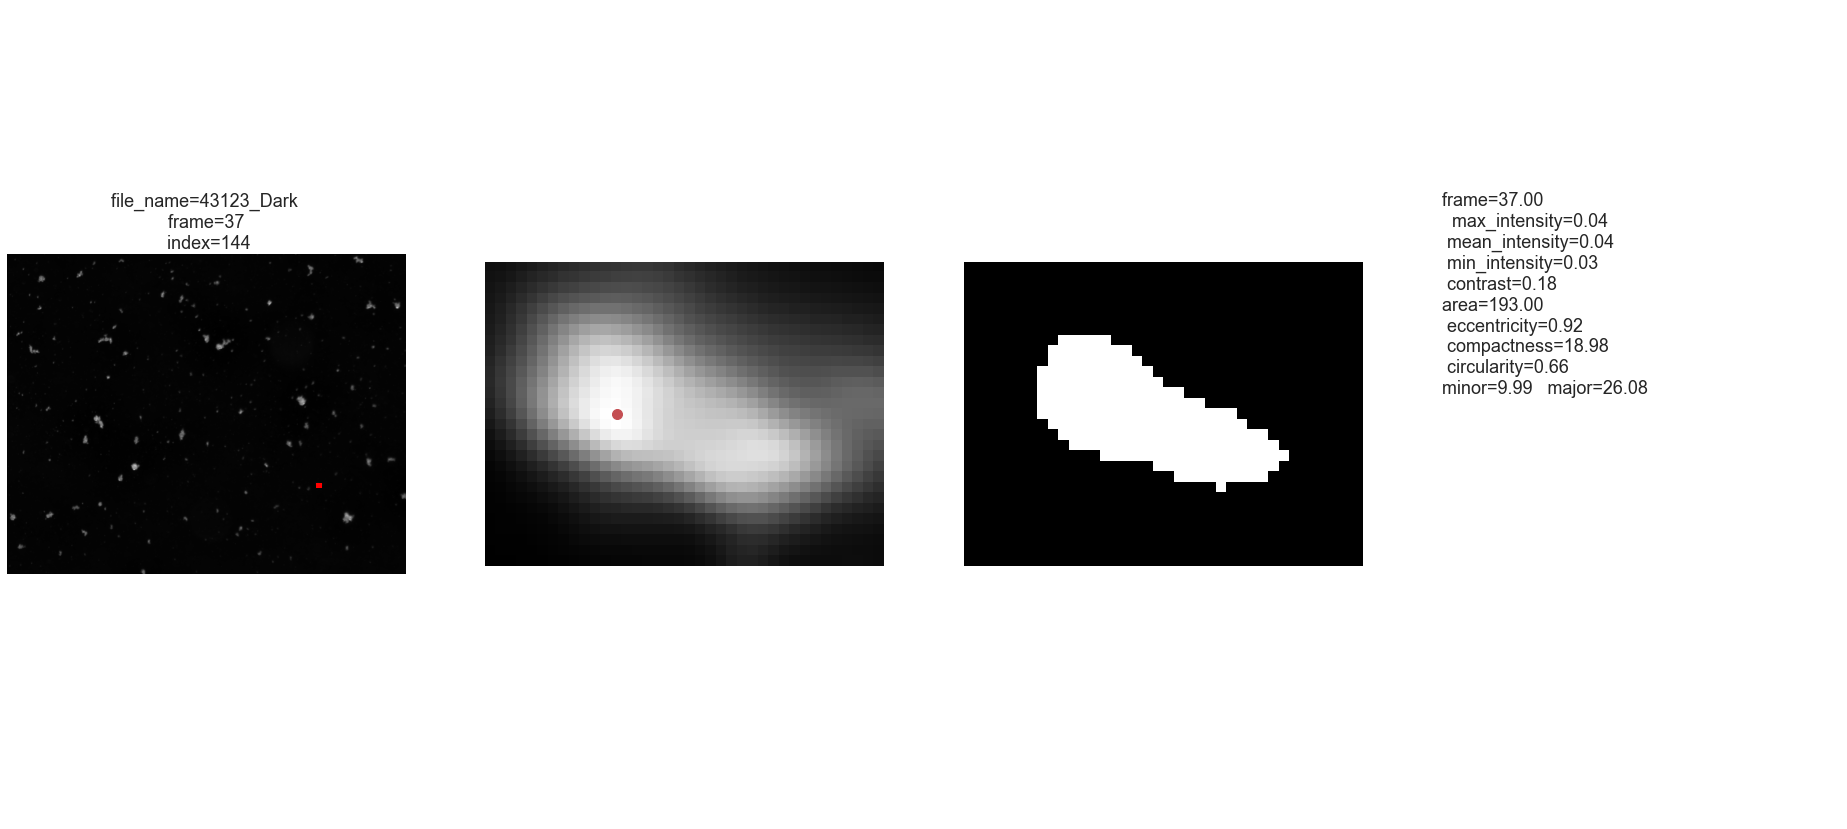

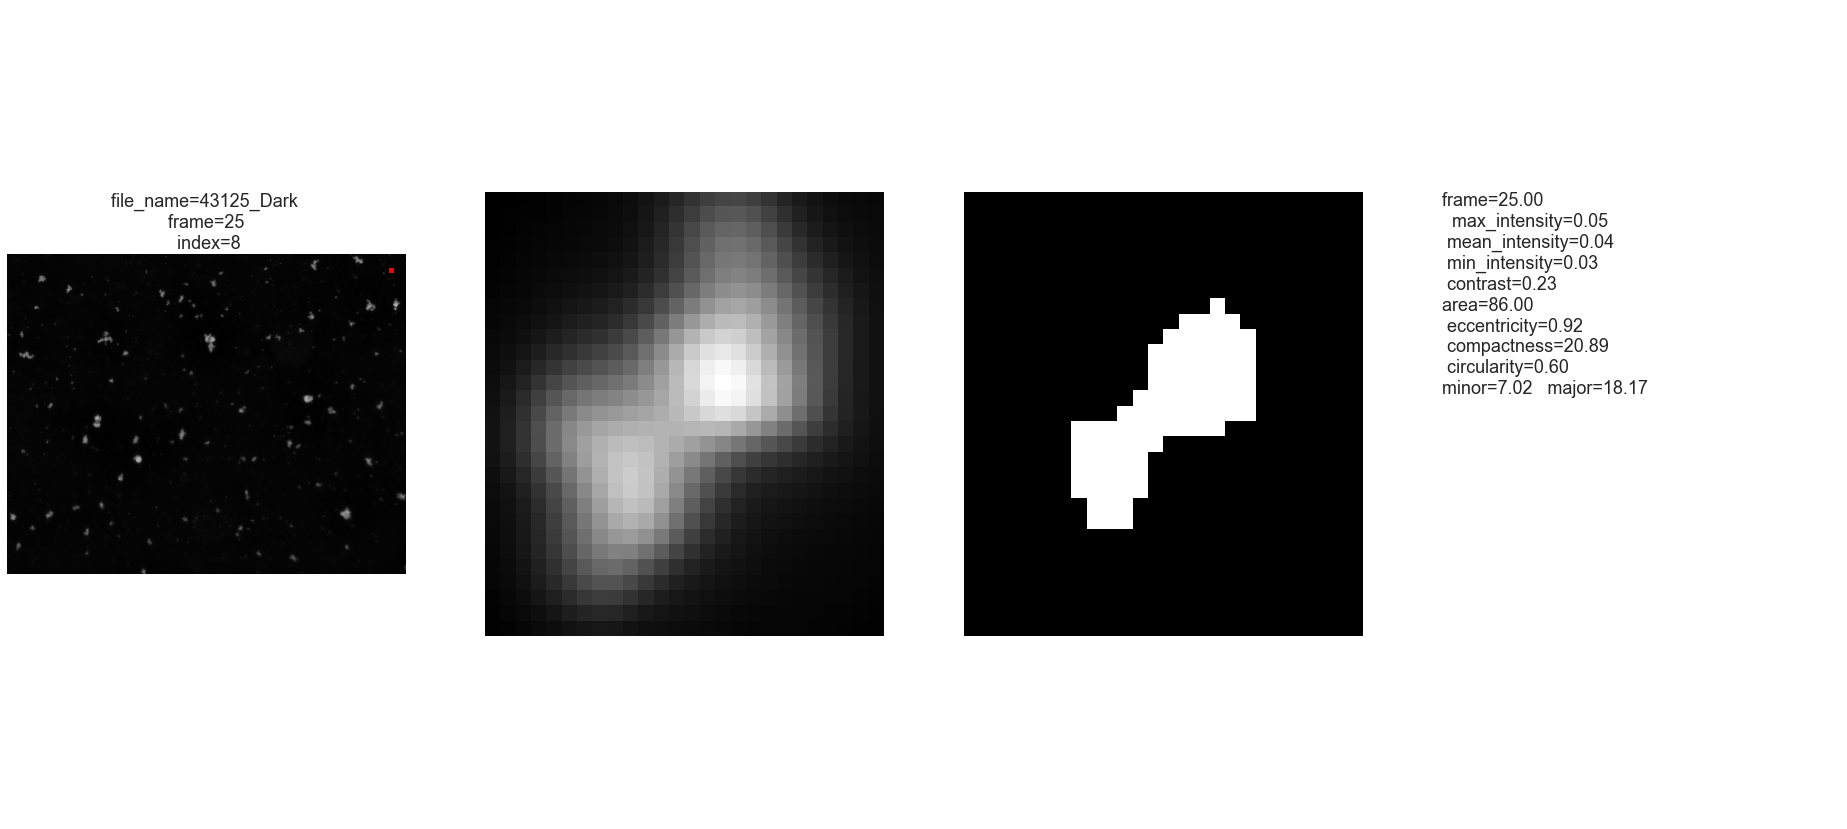

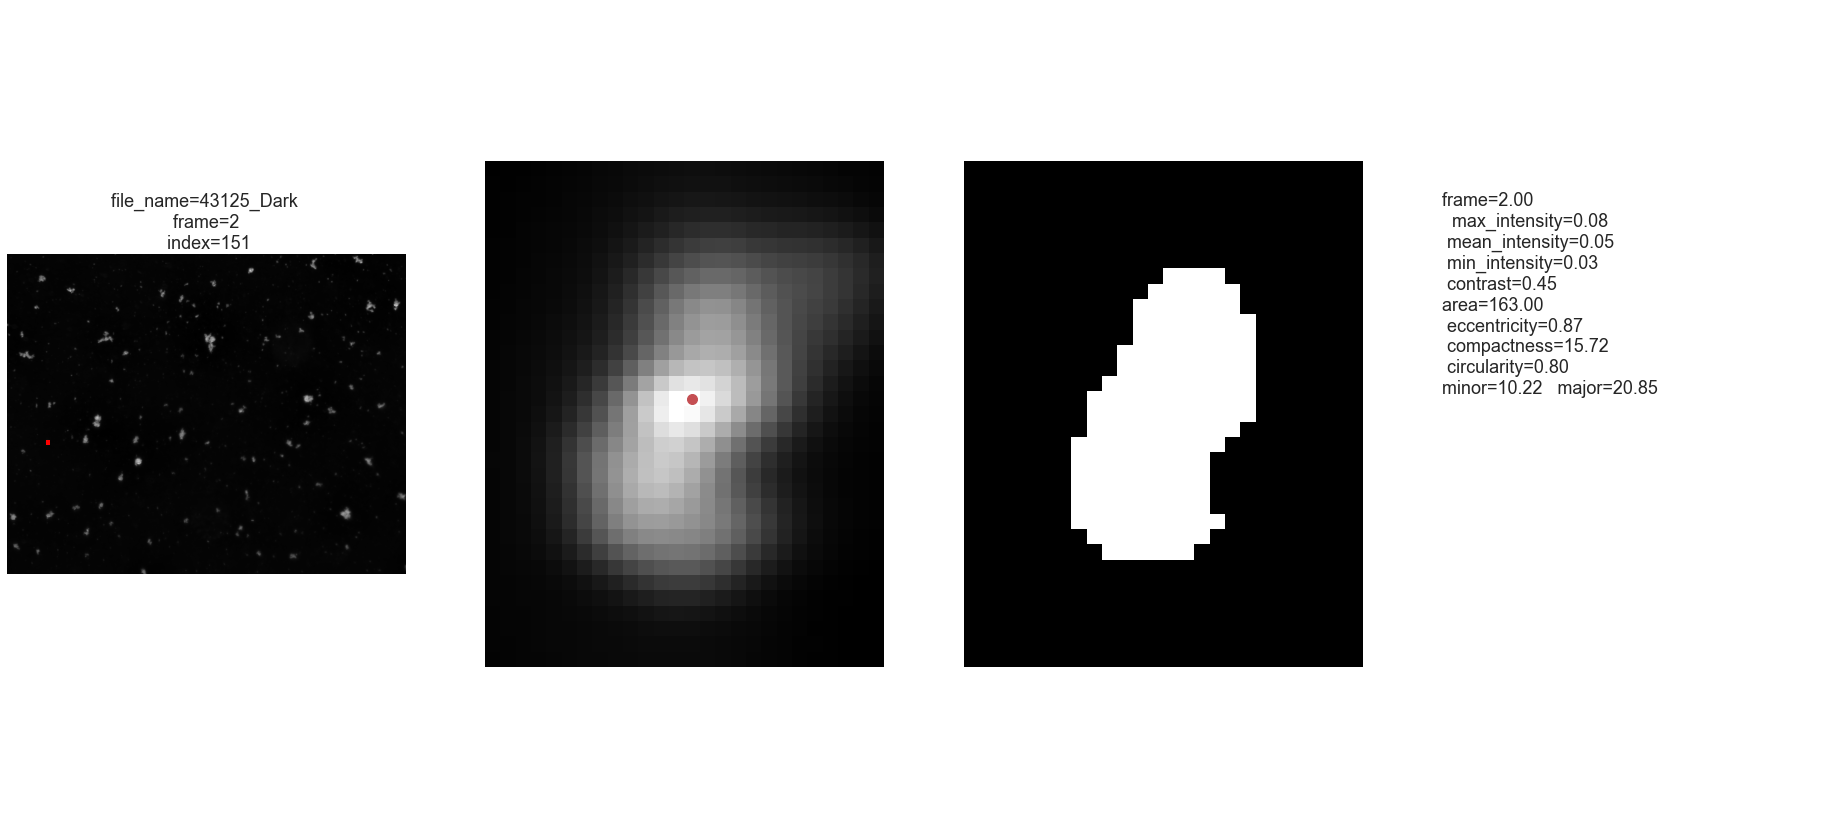

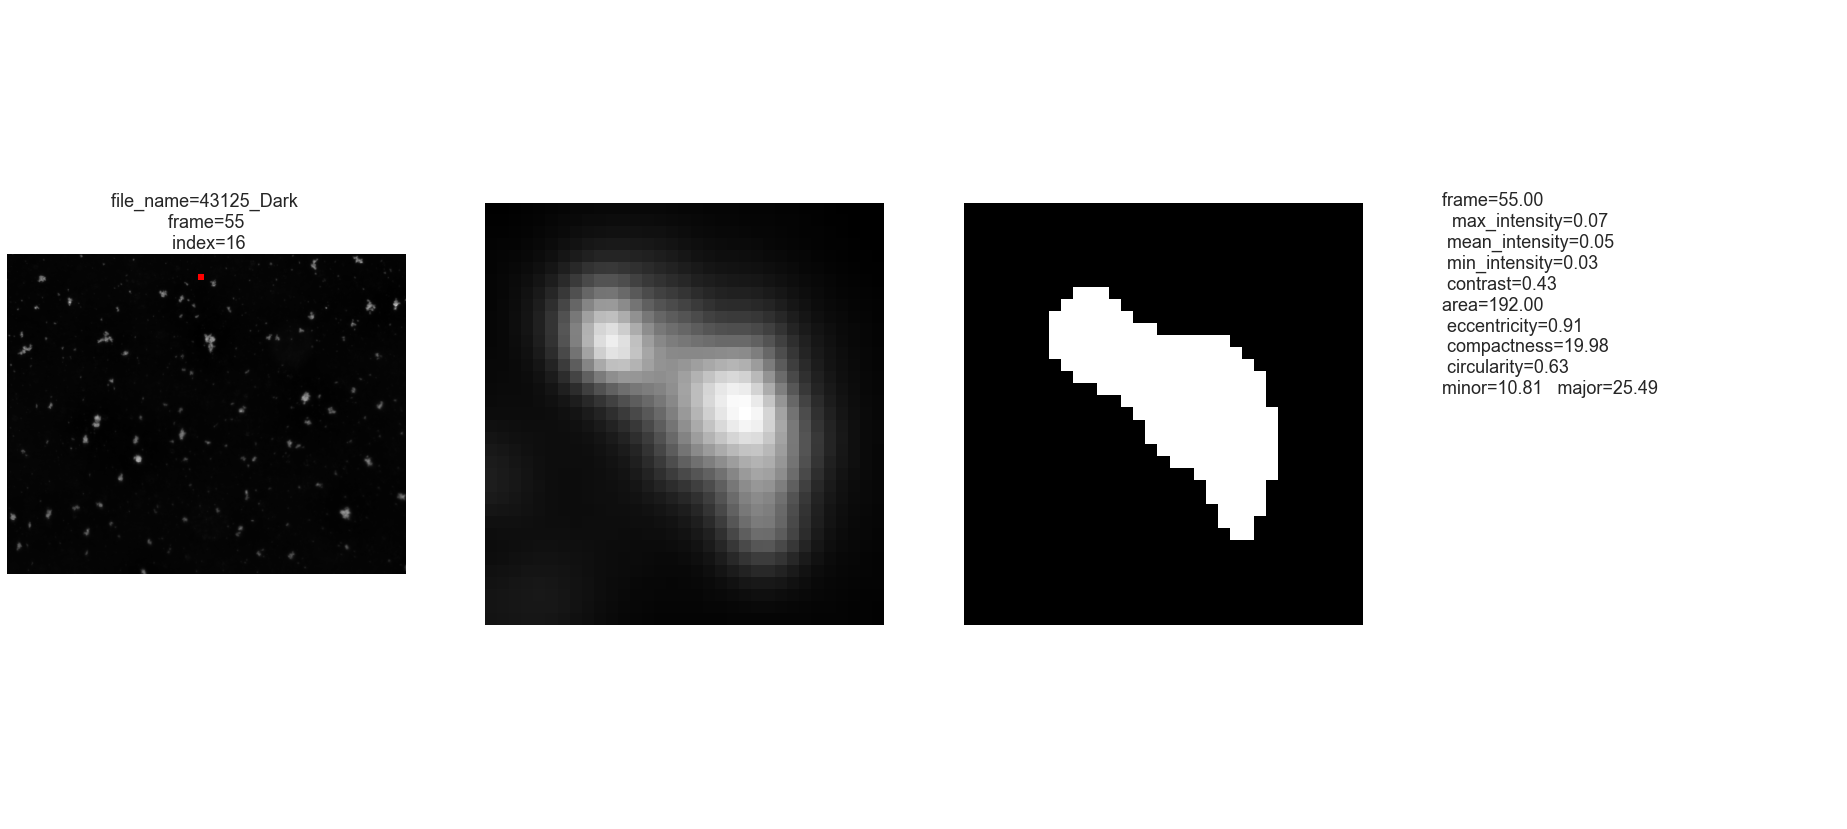

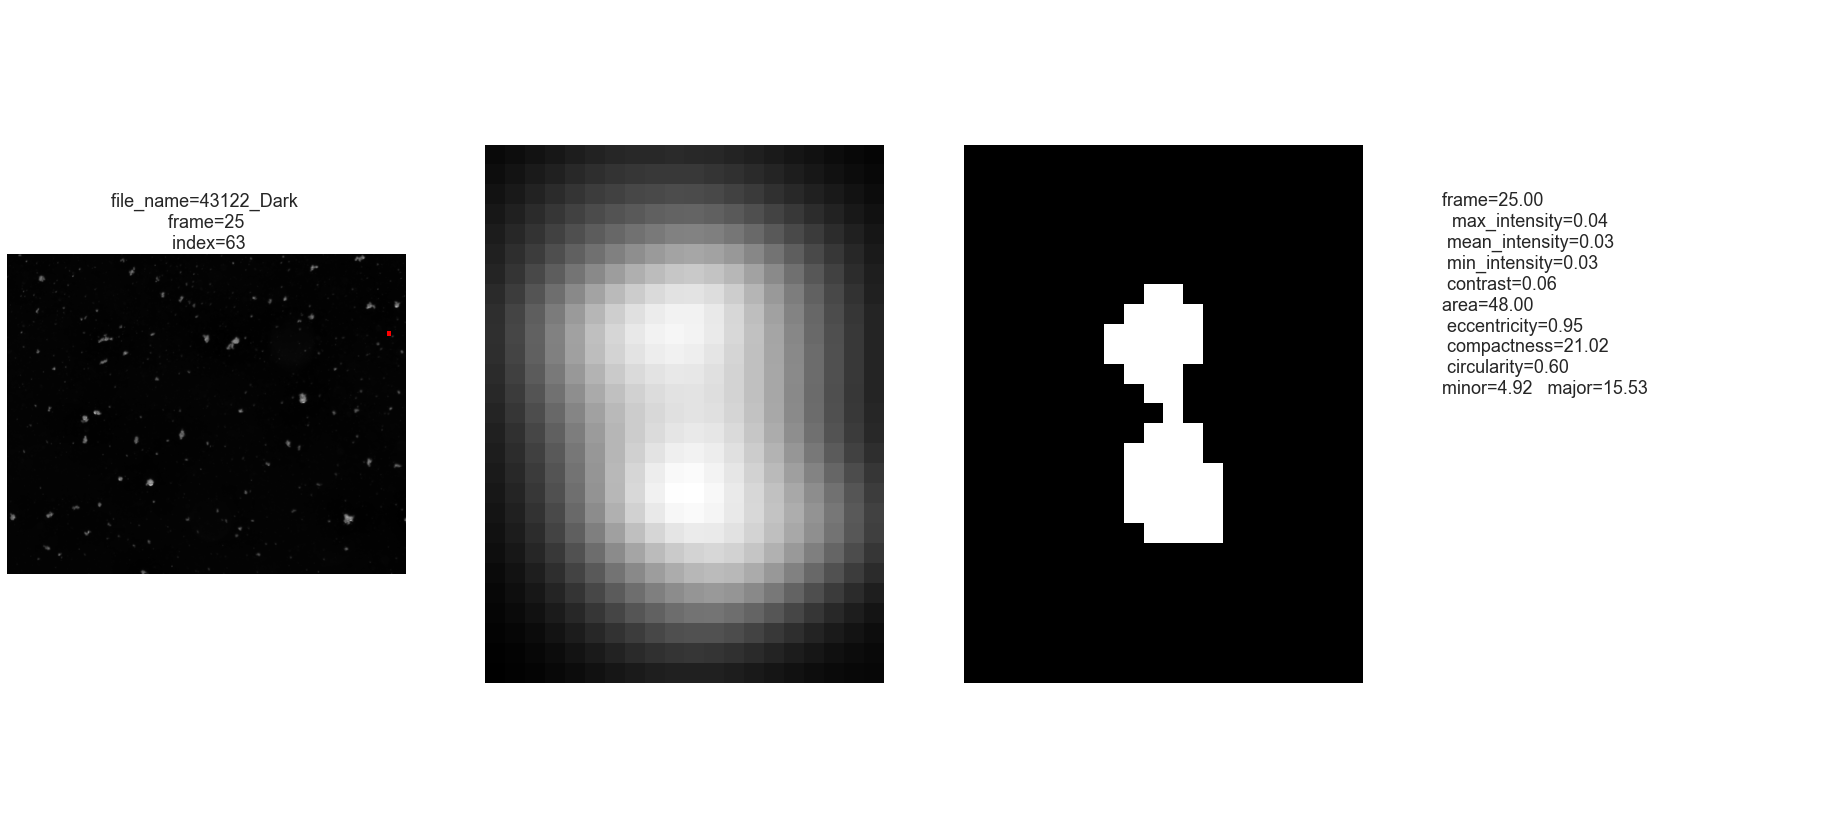

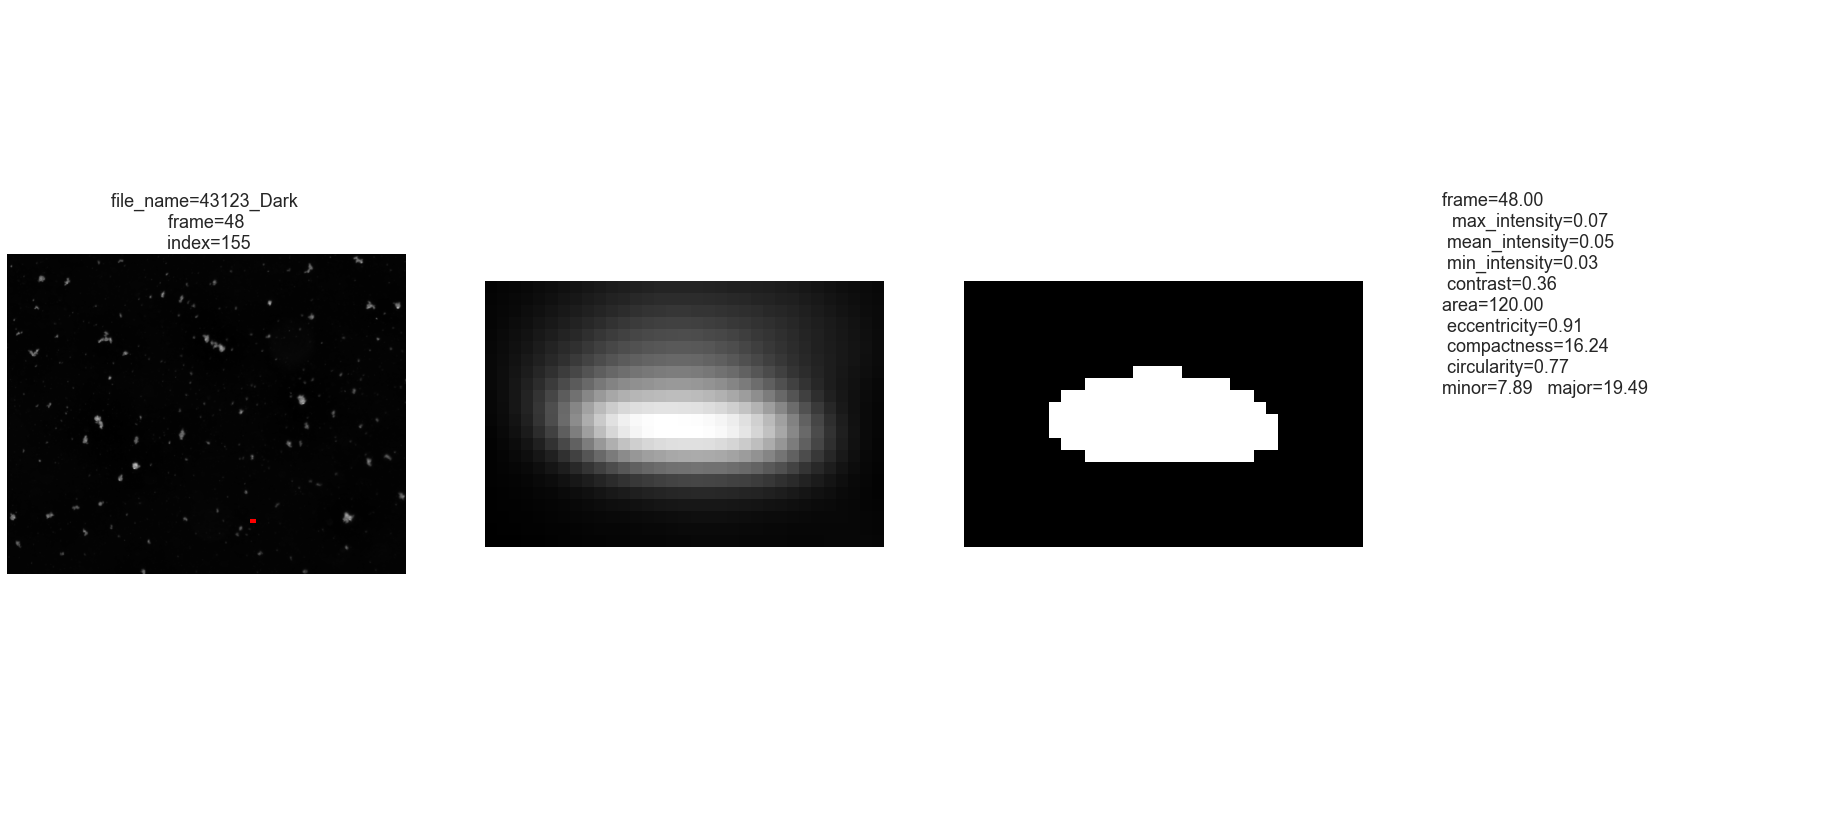

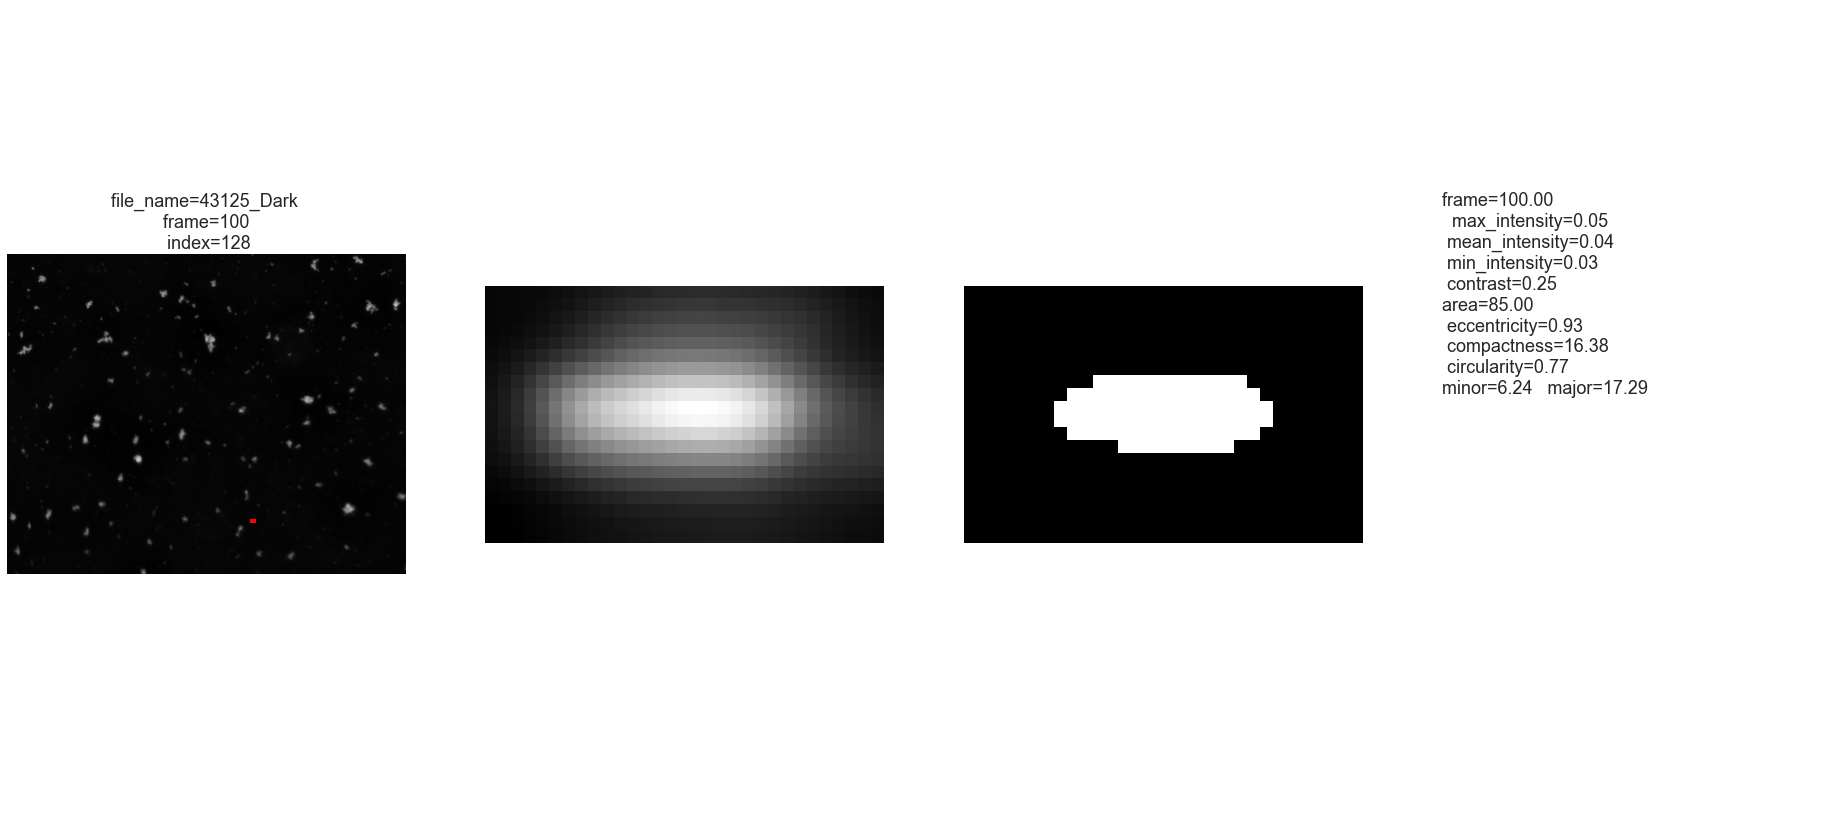

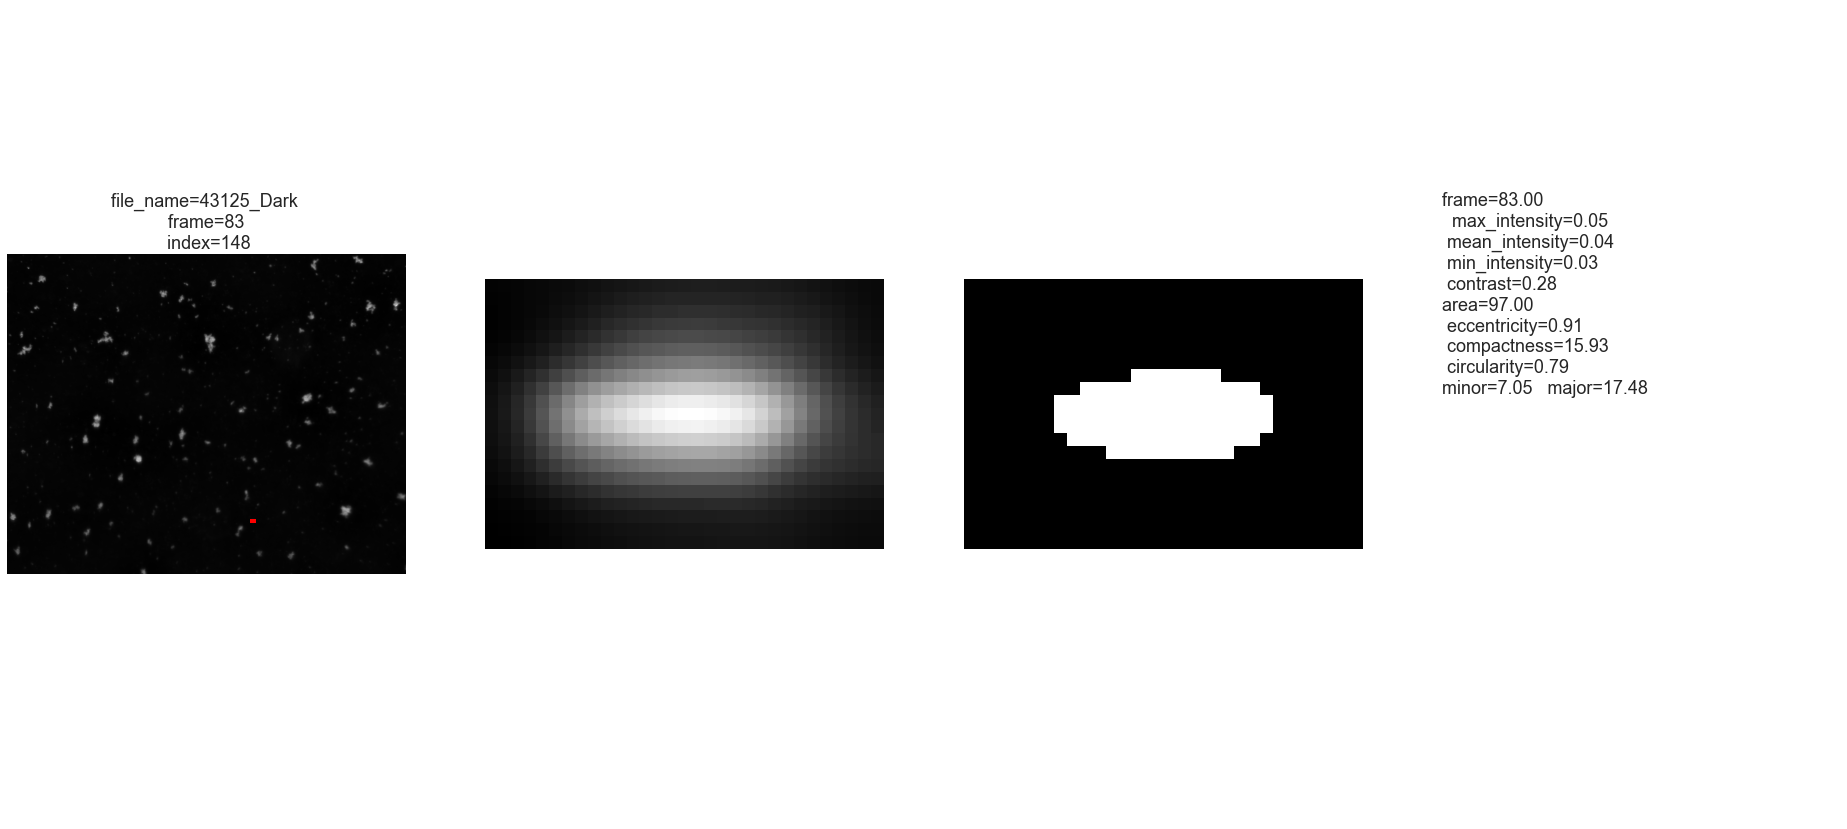

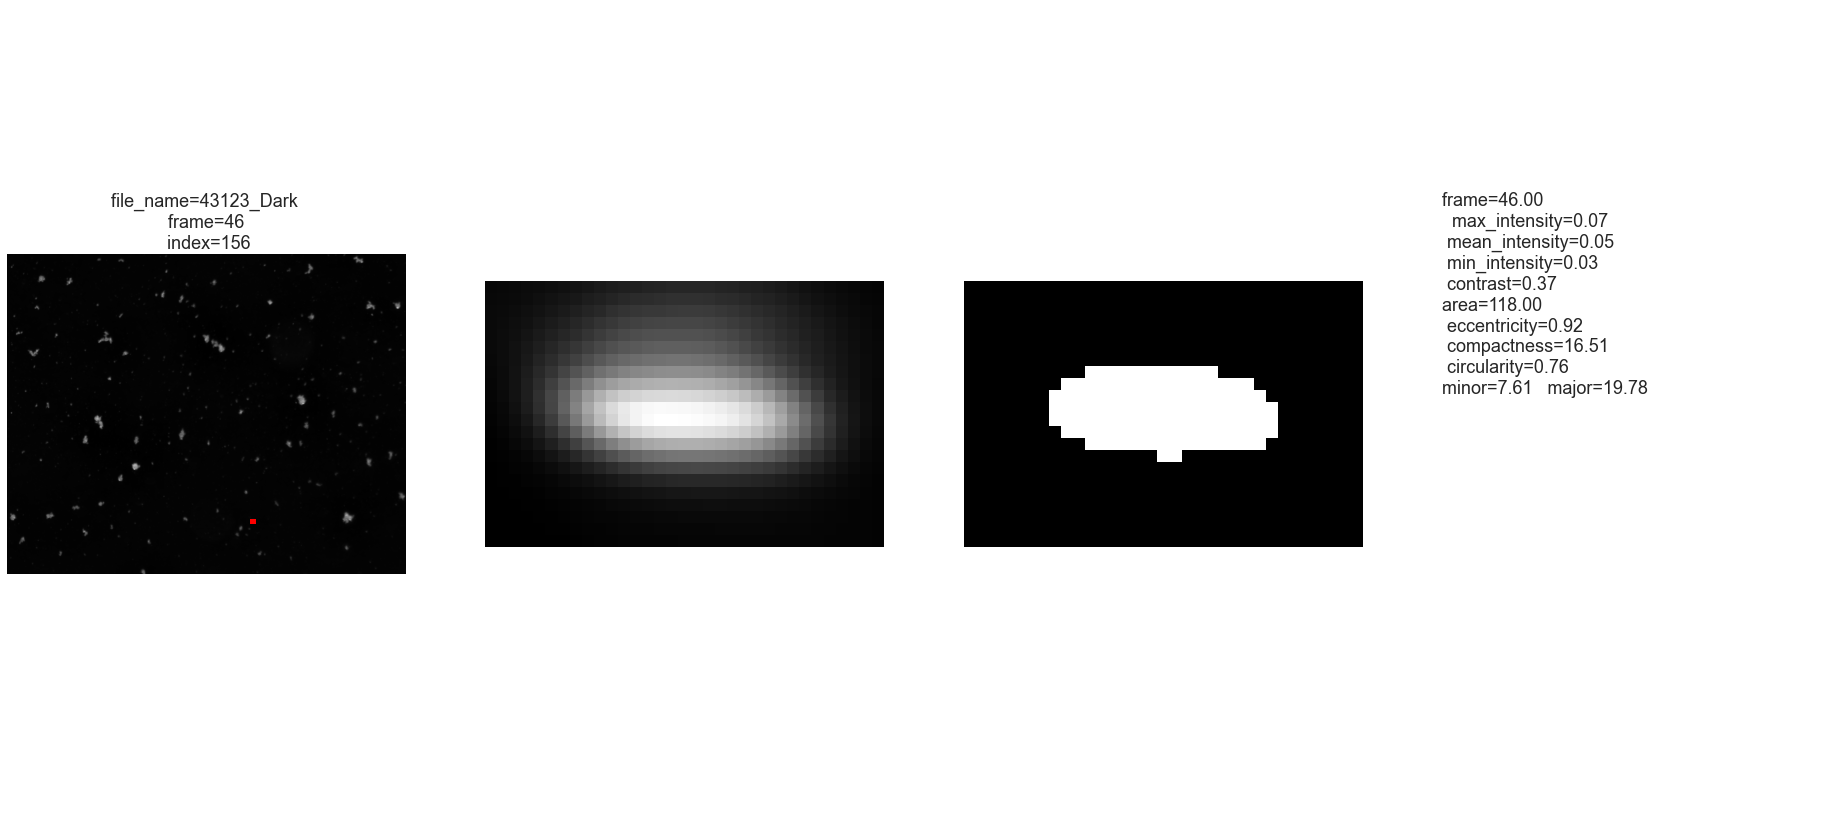

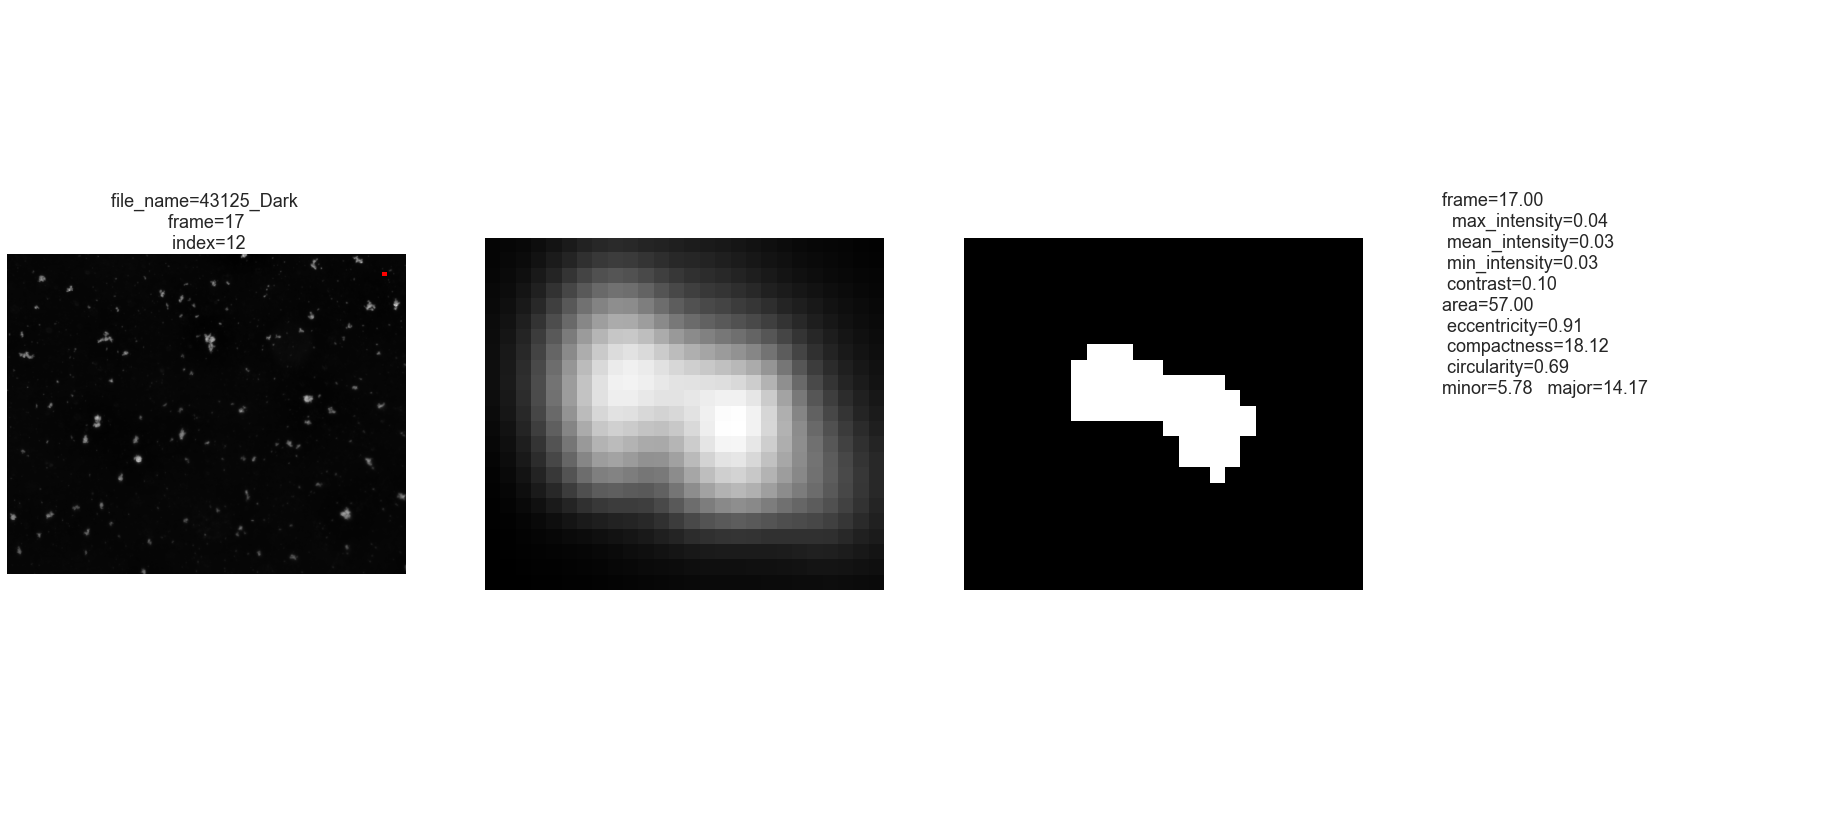

In [16]:
df_select=Data[(Data["compactness"]>15) & (Data["area"]<200)]
df_select=df_select.sample(frac=1)
for idx in df_select.index[:10]:
    plot_one_entity(images_dict,df_select.loc[idx,:])

### cicularity

Text(0, 0.5, 'count')

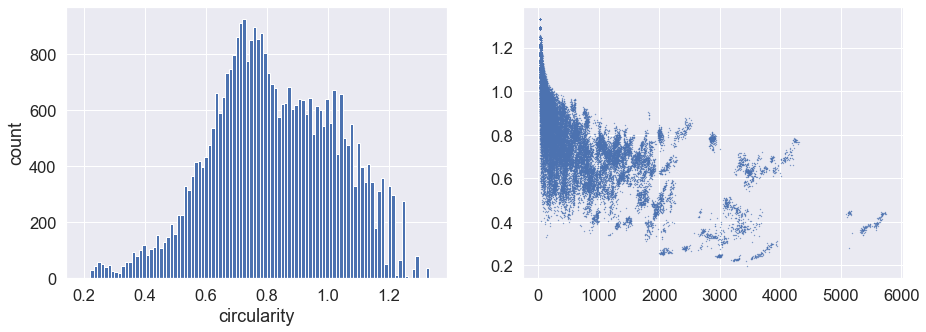

In [17]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,5))
ax[0].hist(Data["circularity"],bins=100)
ax[0].set_xlabel("circularity")
ax[0].set_ylabel("count")

ax[1].scatter(Data["area"],Data["circularity"],s=0.1,)
ax[0].set_xlabel("circularity")
ax[0].set_ylabel("count")


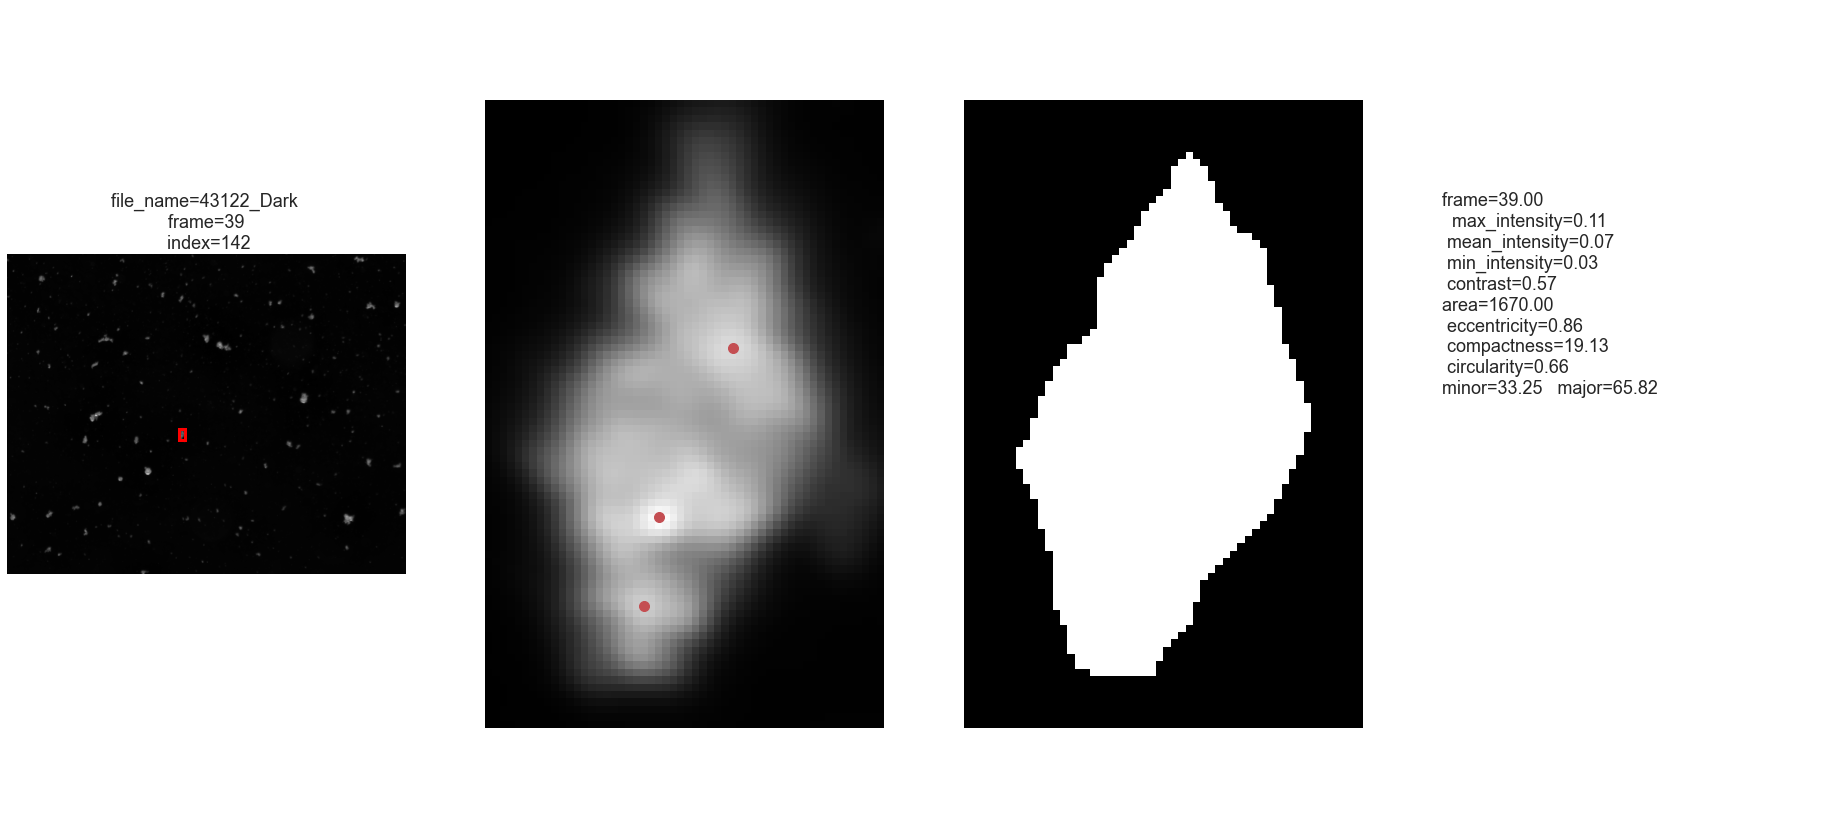

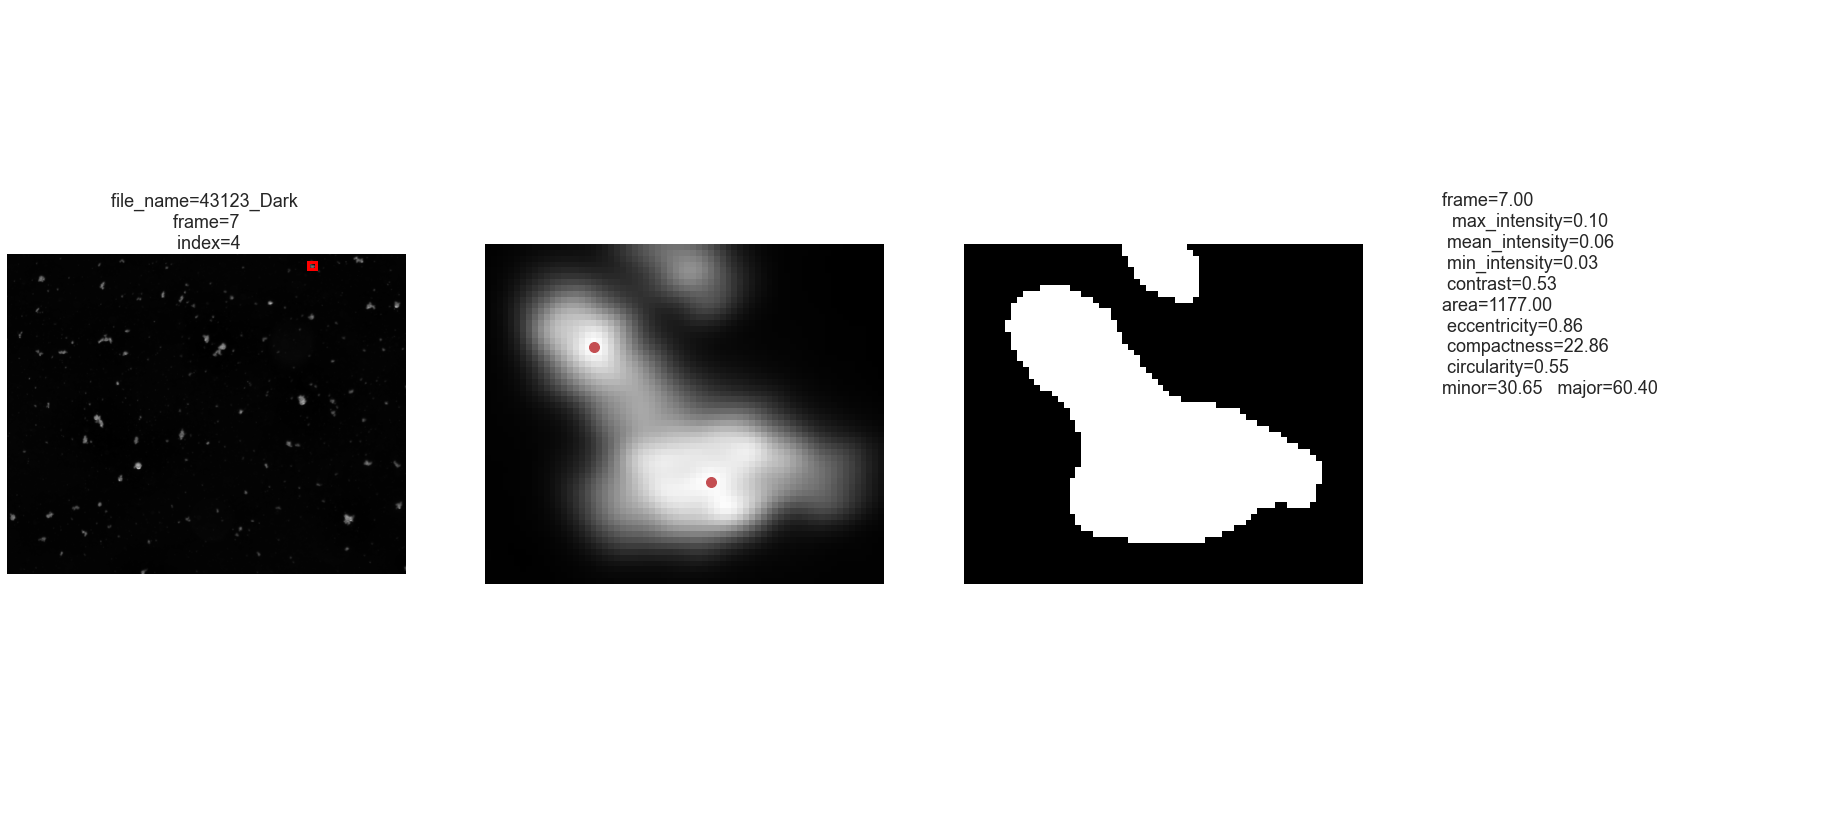

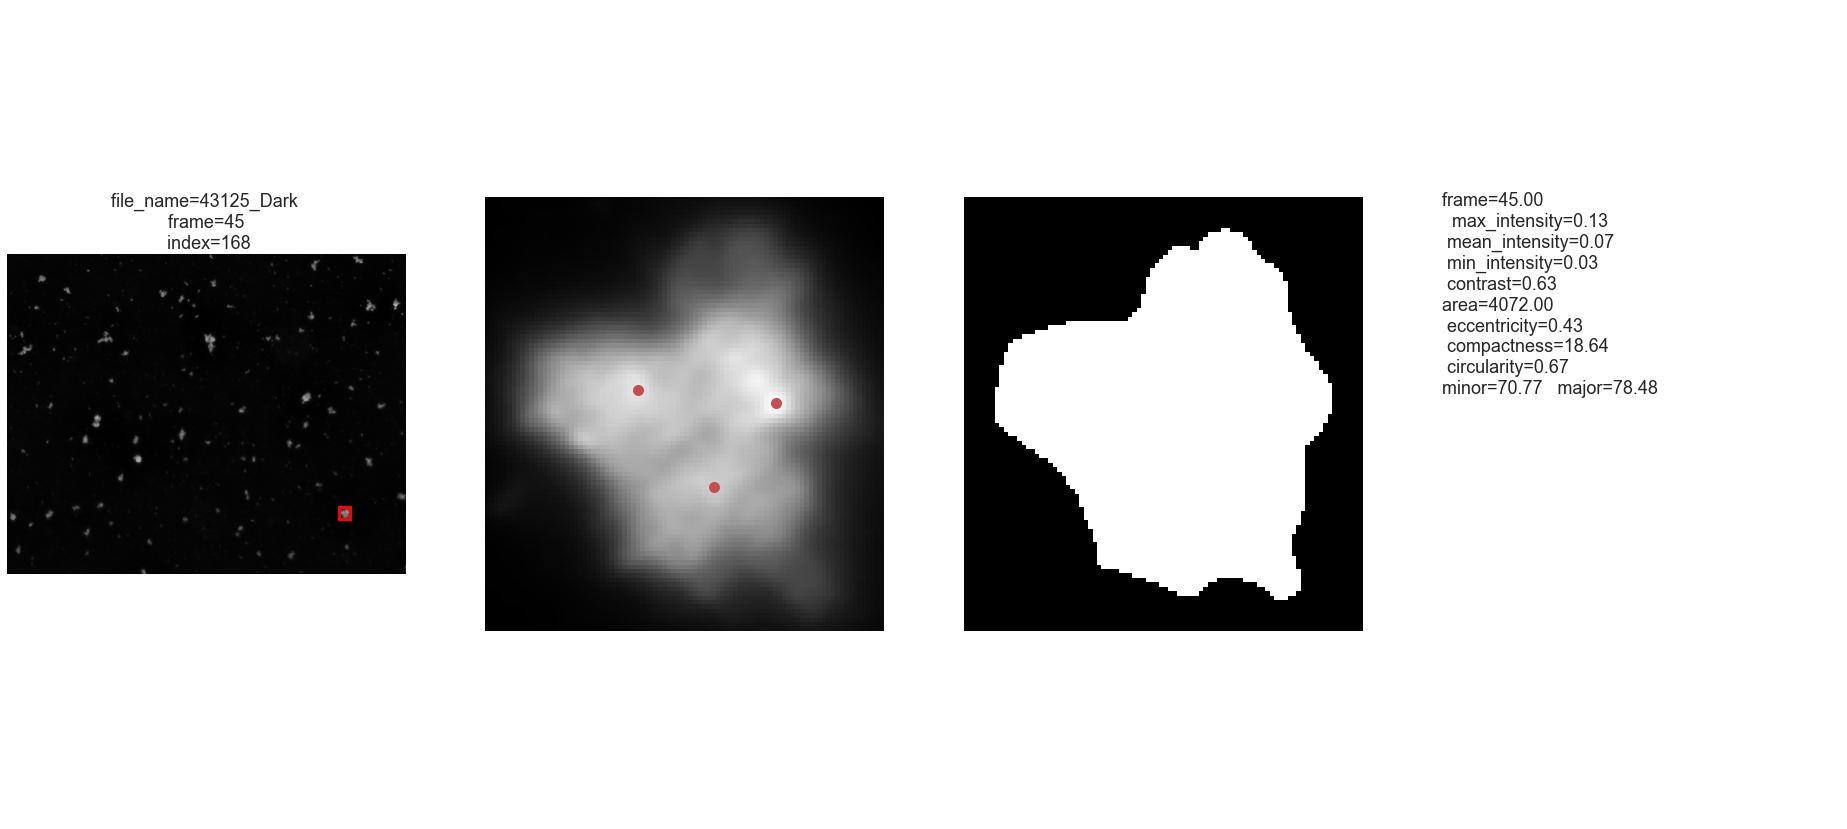

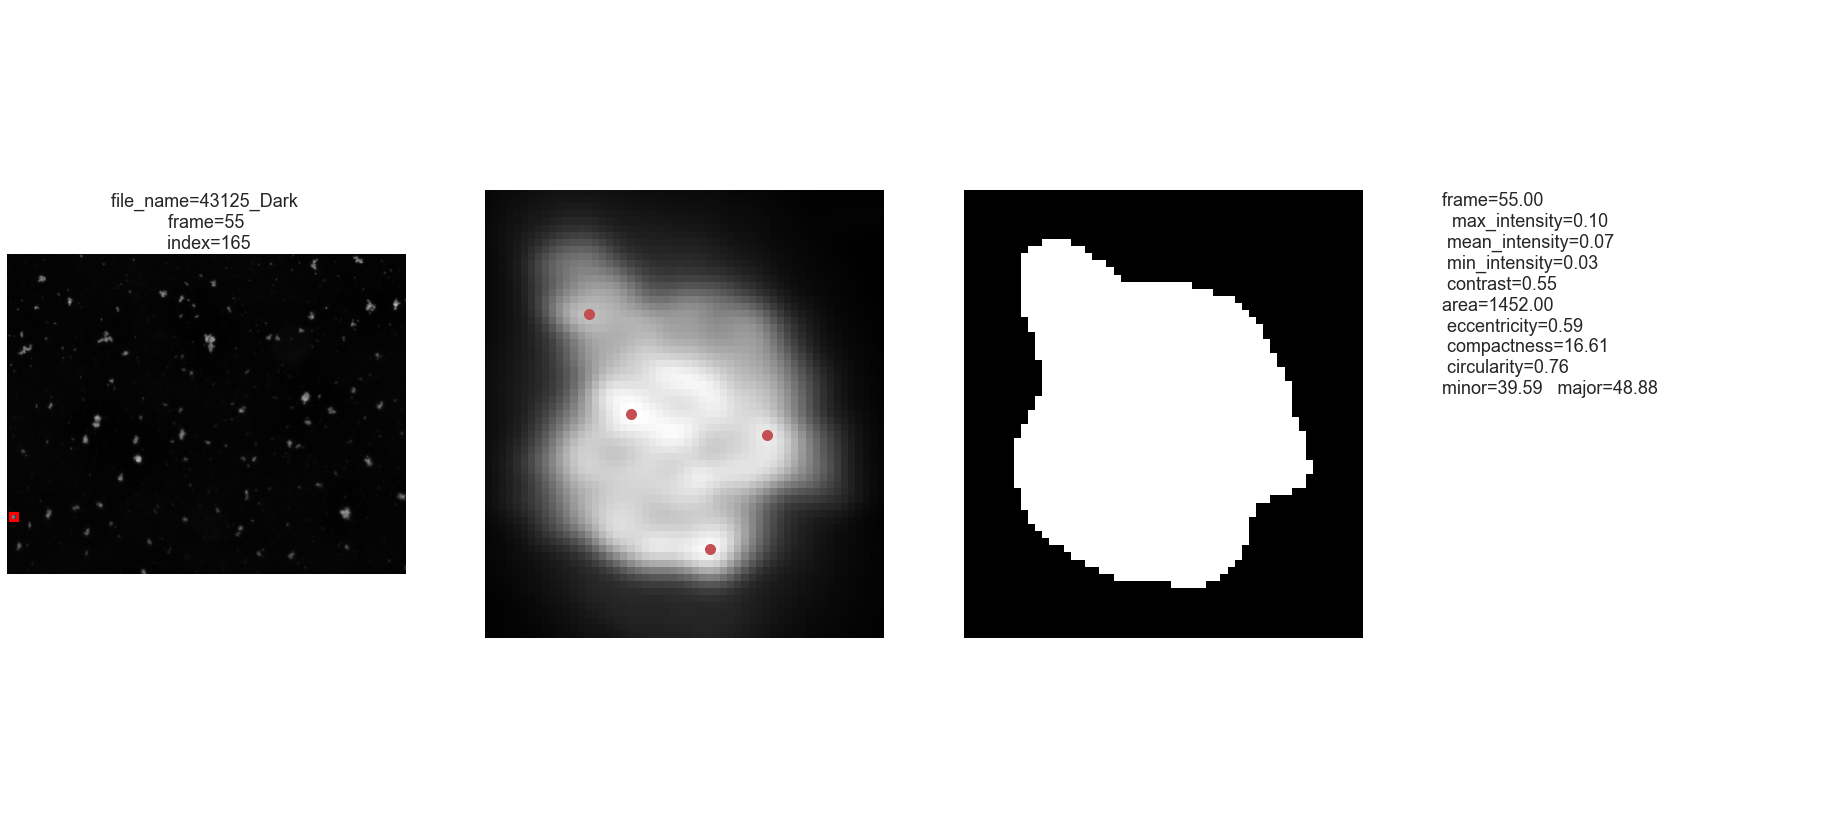

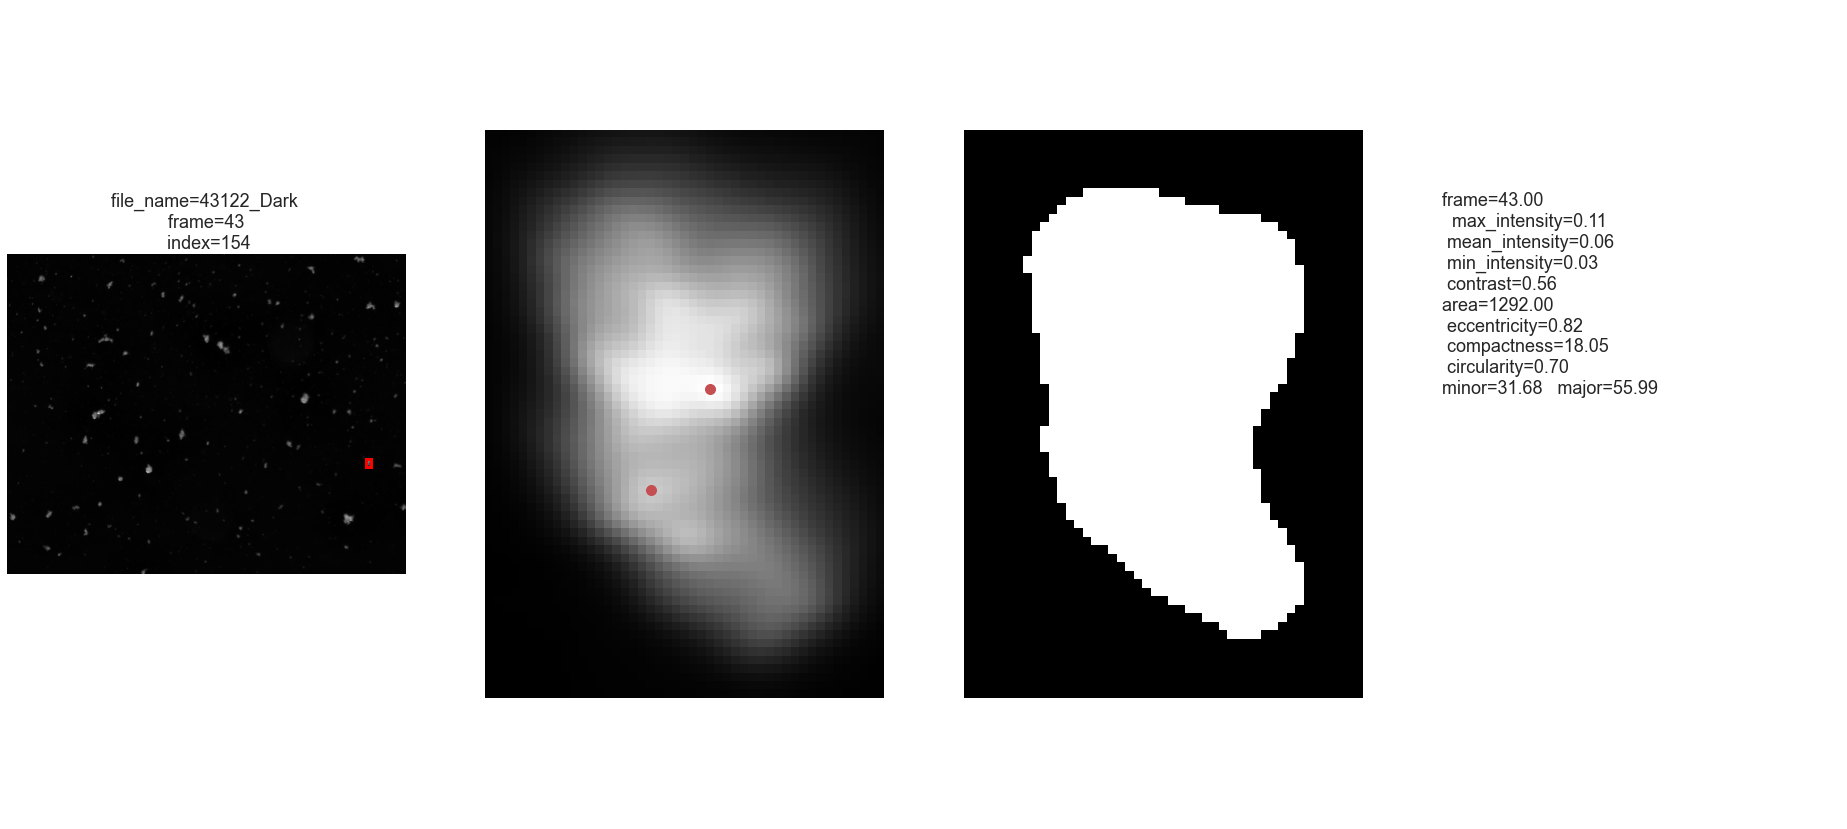

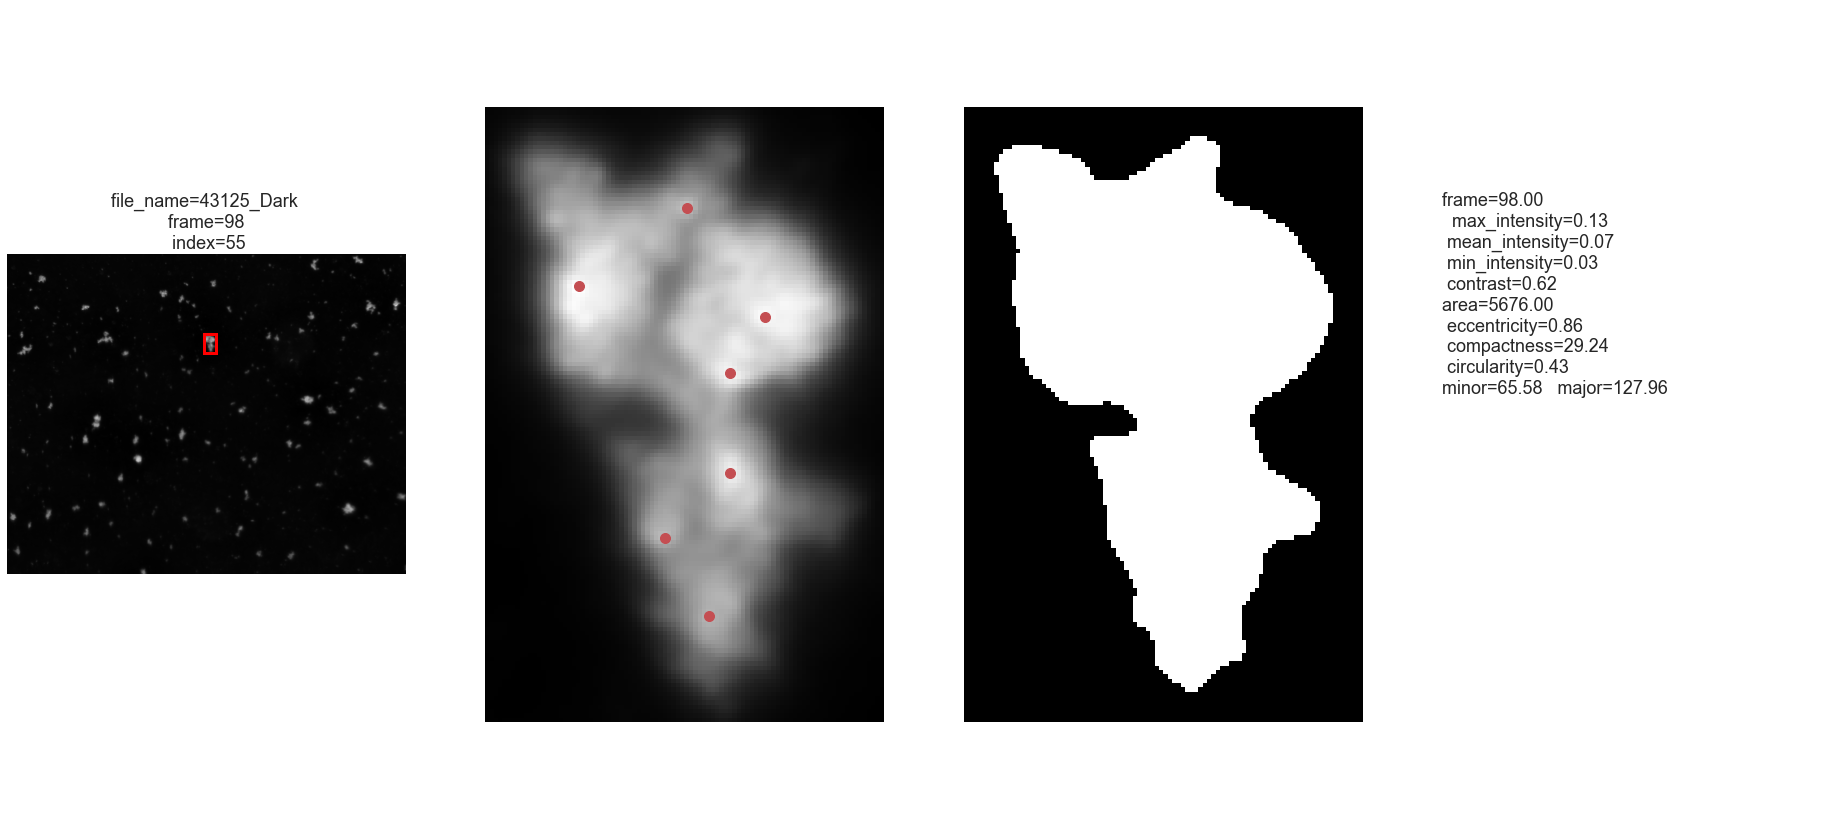

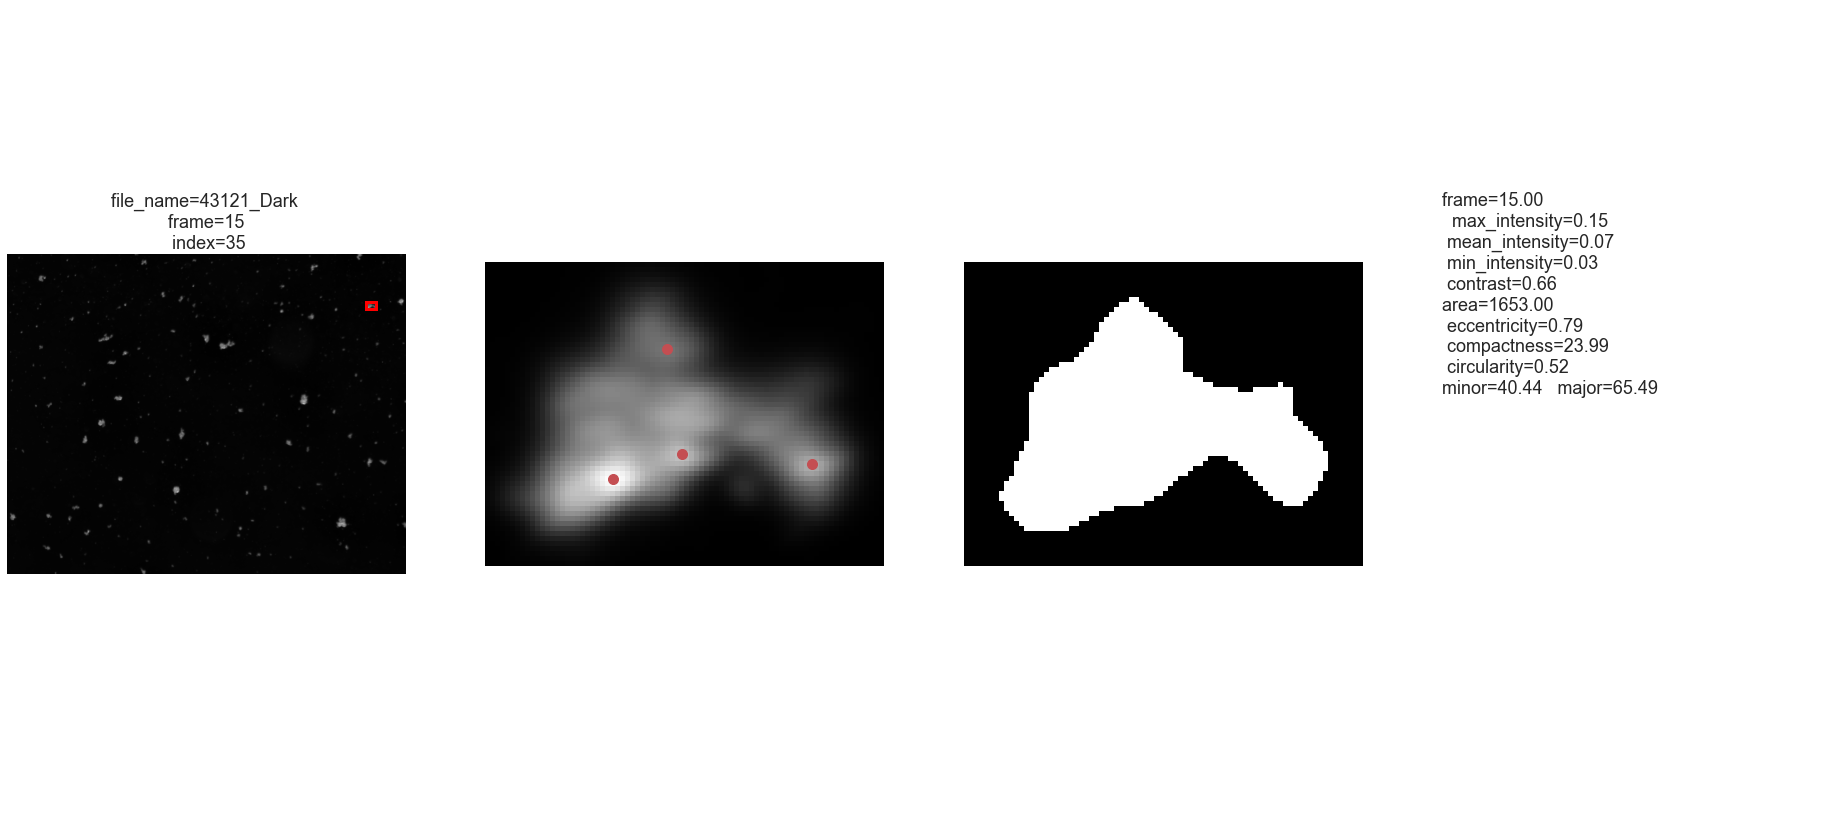

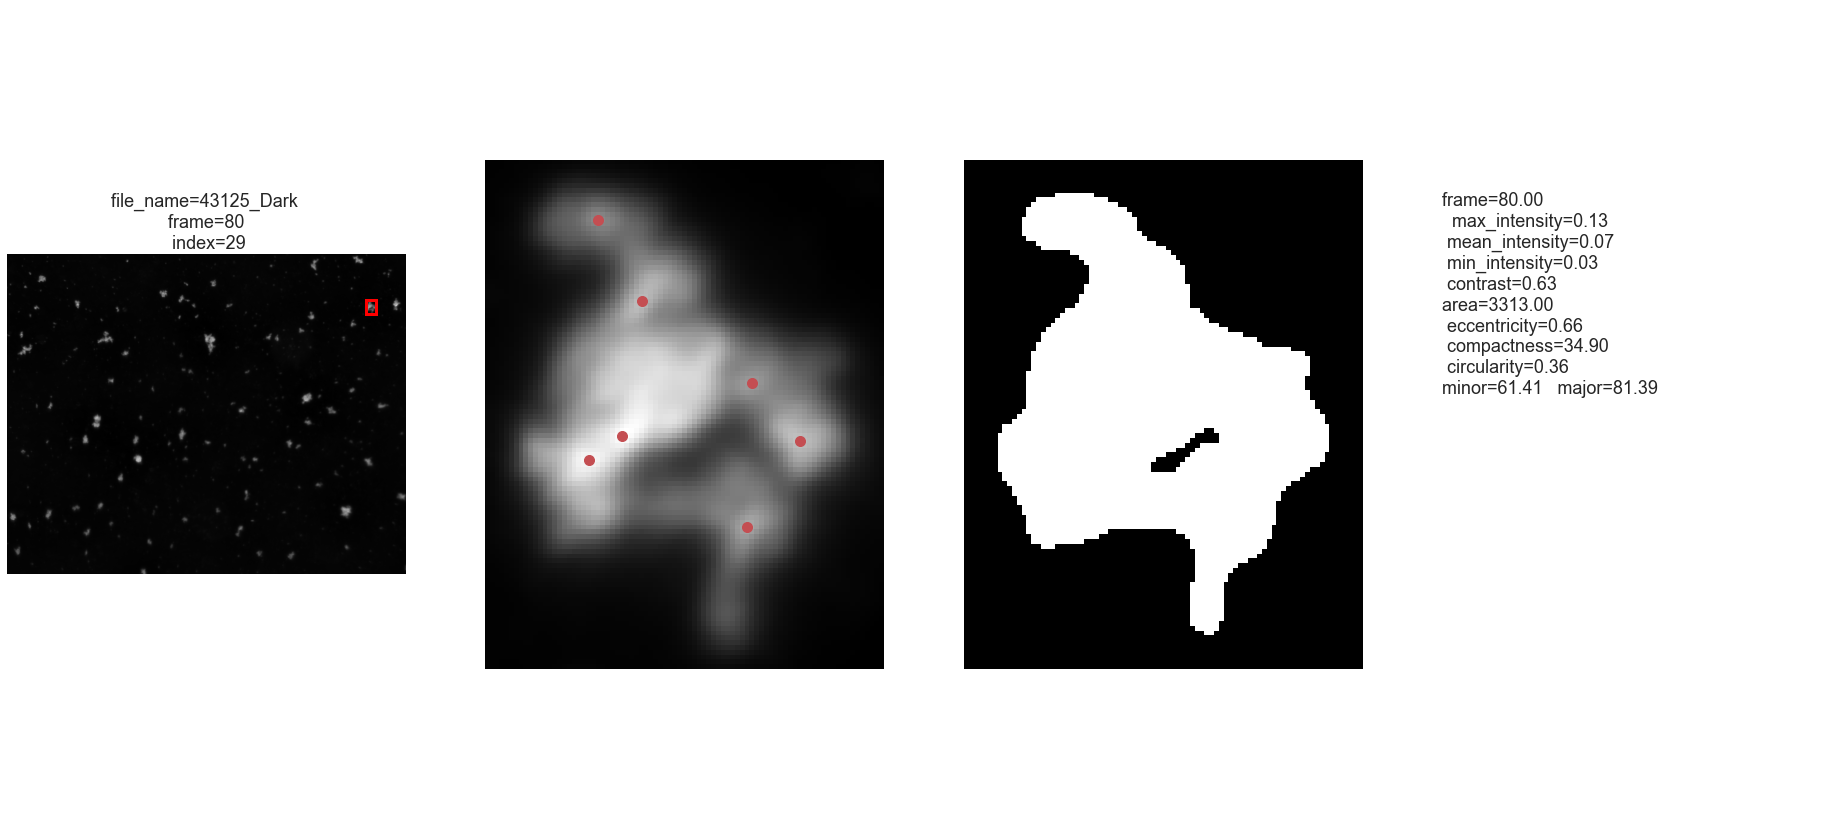

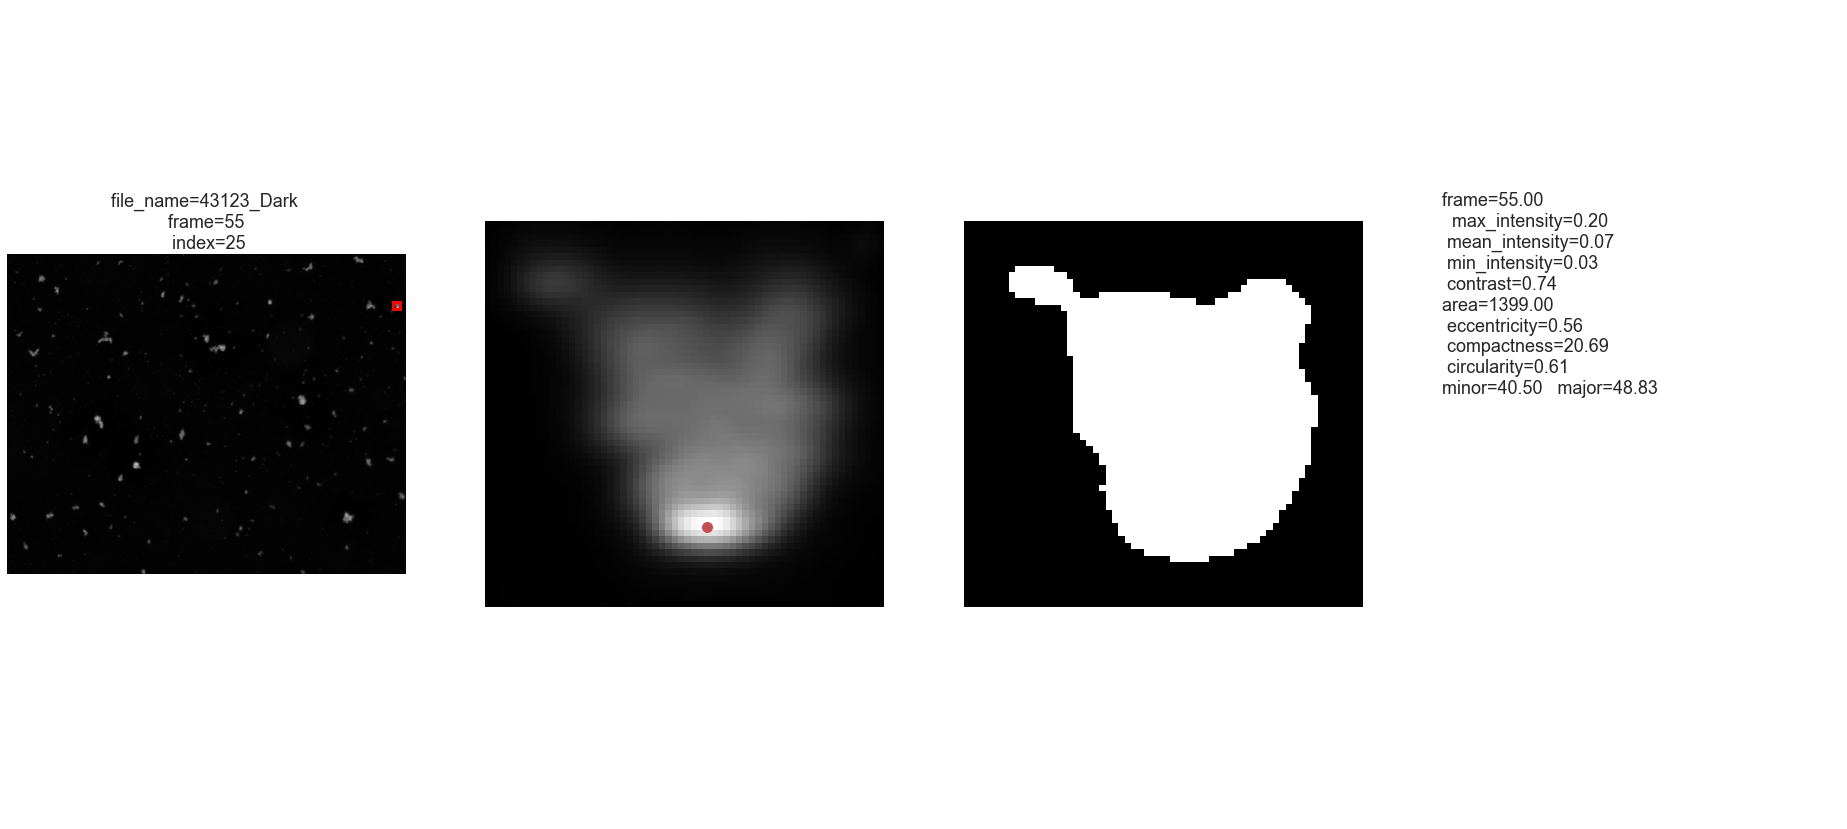

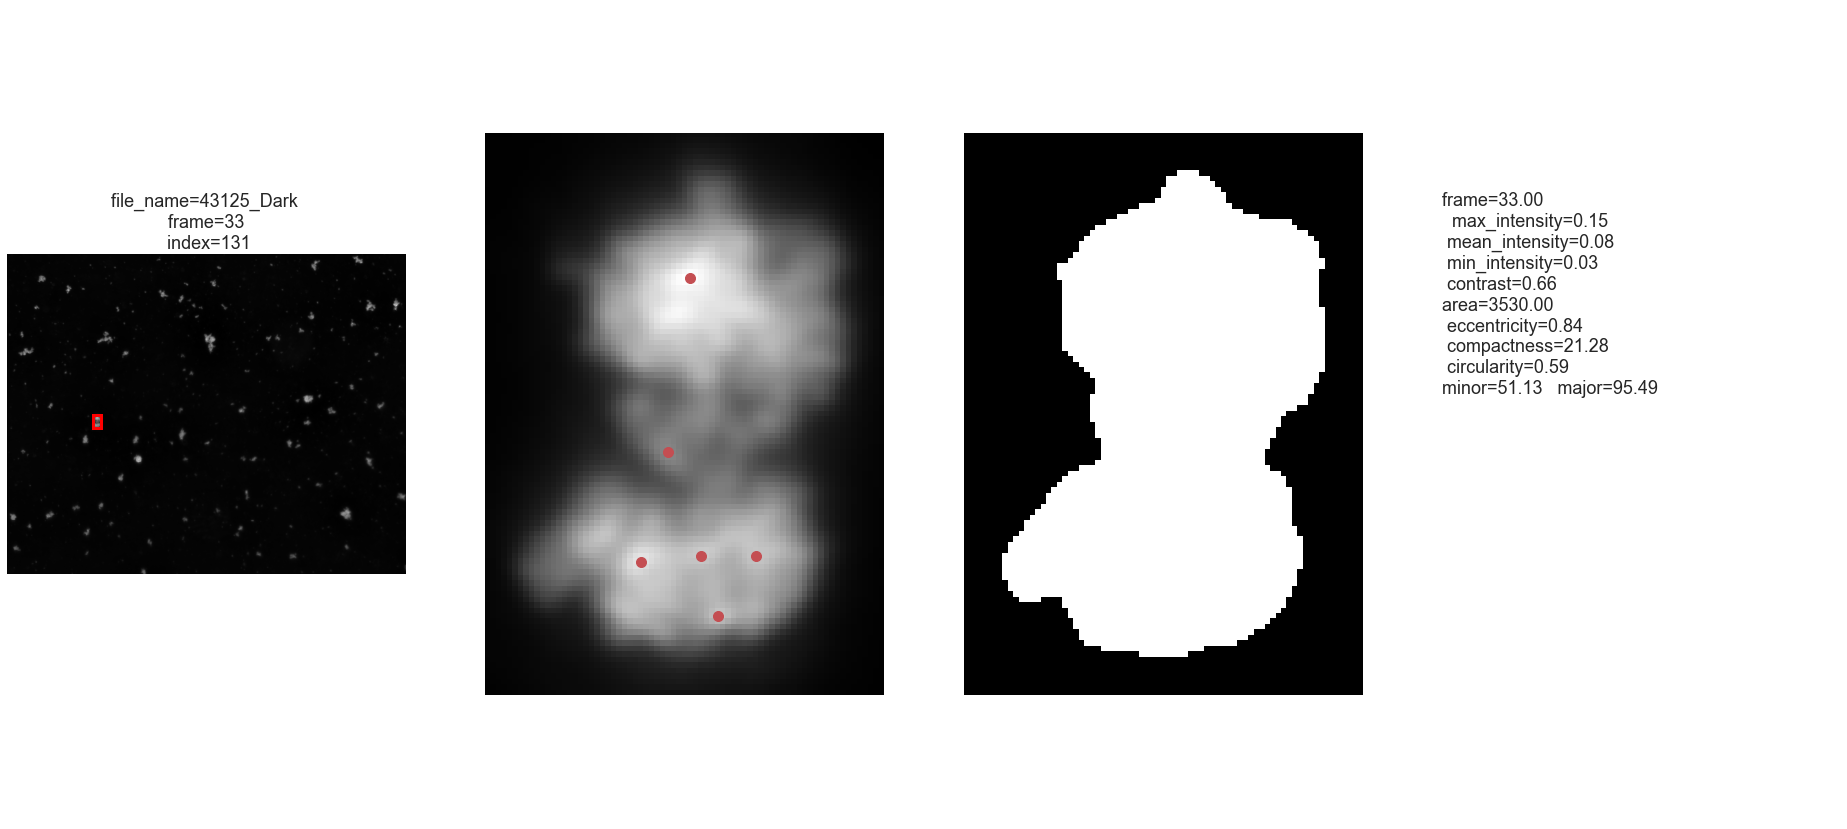

In [18]:
df_select=Data[(Data["circularity"]<0.8) & (Data["area"]>1000)]
df_select=df_select.sample(frac=1)

for idx in df_select.index[:10]:
    plot_one_entity(images_dict,df_select.loc[idx,:])

### Eccentricity

Text(0.5, 0, 'area')

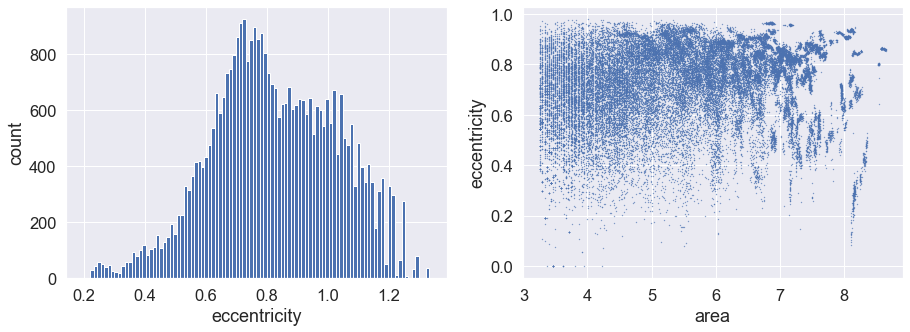

In [19]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,5))
ax[0].hist(Data["circularity"],bins=100)
ax[0].set_xlabel("eccentricity")
ax[0].set_ylabel("count")

ax[1].scatter(np.log(Data["area"]+1e-6),Data["eccentricity"],s=0.1,)
ax[1].set_ylabel("eccentricity")
ax[1].set_xlabel("area")